In [7]:
import os, sys

import pymongo as pm
import numpy as np
import scipy.stats as stats
import math
import pandas as pd
import json
import re
from io import BytesIO
from PIL import Image
import requests # this is to access the stim urls from the notebook
from IPython.display import SVG, display # need for showing stims with sketches side by side
import base64
import PIL

import matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.patches as mpatches
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from matplotlib import rcParams
matplotlib.rcParams['pdf.fonttype'] = 42

from IPython.display import clear_output
import importlib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# so dataframes don't get cut off in display:
pd.set_option("display.max_rows", None, "display.max_columns", None)

import ast  # for interpreting strings as dictionary objects

# if you want the cells to be the width of your browser
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [8]:
import networkx as nx
import igraph as ig

### establish connection to mongo
first thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

ssh -fNL 27020:127.0.0.1:27017 USER@cogtoolslab.org

In [9]:
! ssh -fNL 27020:127.0.0.1:27017 sholt@cogtoolslab.org

In [10]:
# set vars 
auth = pd.read_csv(os.path.join(os.getcwd(),'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
import socket
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn['num_syn']
coll = db['proof_of_concept']

# which iteration name(s) should we use?
iterationName = 'sandbox2'  # 'sandbox', 'friends1' (Leo & Emily), 'pilot1' was more people we know, 'pilot2' was 5 games on Prolific
# 'sandbox1' was us trying to pilot among ourselves a larger base of 8, 'run2' is study 2 (base-8 & 10)
# 'pilot2_1' is our sanity check about bonus money, and 'pilot3_1' is for piloting the sequence-manipulation experiment
iterationNames = ['run1' , 'run2' , 'repair1'] # 'pilot2_1' , 'pilot3_1' , 'run1' , 'run2' , 'repair1'

iteration = 'old' # 'old' or 'new'
if iteration == 'new':
    w = coll.find({'iterationName':iterationName})
else:
    w = coll.find({'iterationName':{'$in': iterationNames}})
    
W = pd.DataFrame(w)
Wraw = W

# get rid of the faulty base-3 condition from the first run, where the number '9' was not formed correctly
excludeThisBase3 = 'run1'
W = W.drop(W[(W['base'] == 3) & (W['iterationName'] == excludeThisBase3)].index)
Wraw = Wraw.drop(Wraw[(Wraw['base'] == 3) & (Wraw['iterationName'] == excludeThisBase3)].index)


print("Done")

Done


In [11]:
# Quickly anonymise the gameIDs and cast a few columns into the forms we want them to be
W[['gameID']] = W[['gameID']].applymap(lambda x: "G" + str(int(np.where(W.gameID.unique() == x)[0])+1))
Wraw[['gameID']] = Wraw[['gameID']].applymap(lambda x: "G" + str(int(np.where(Wraw.gameID.unique() == x)[0])+1))
W = W.astype({'correct':'float',
              'totalScore':'float'})
W = W.rename(columns={'writingTime':'WT'})

In [215]:
# only new

# W#[W['eventType']=='generalization']#[['eventType','']]

# lastOrdinals = W[W['eventType']=='ordinality'].groupby('prolificID')['trialStartTime'].max()
# W[W['trialStartTime'].apply(lambda x: x in list(lastOrdinals))][['prolificID','score']].sort_values('score')
# W[W['trialStartTime'].apply(lambda x: x in list(lastOrdinals))][['prolificID','totalScore']].sort_values('totalScore').plot.bar(ylim=(0,390))

In [13]:
###################################### coll.delete_many({'iterationName':'sandbox2'})

W.base.unique()
# for x in W[W['eventType'] == 'survey'][['comments']].iterrows():
#     print(x[1][0])
    
# W.columns

array([ 4,  2,  5, 10,  8,  3])

In [12]:
def parse(string, units, measure='len'):
    """
    Take a string that participant gave, and a list of strings (units in number system).
    Looks to see if the participant's response can be broken down into units.
    Return either how many units could be found, or the remaining length of the string.
    """
    st = string # I never remember if you need to make a shallow copy this way
    ct = 0      # count how many 'units' there are in message
    for unit in units:
        ct += st.count(unit)
        st = st.replace(unit,'-') # placeholder so we don't accidentally produce a syllable in unit list
        
    st = st.replace('-','') # now remove the placeholder
#     answer = ct if measure == 'count' else len(st) # decide which number to give
    return np.array([ct,len(st)])


parse("tiritaritoto",['t','a'])




def gloss(string,system):
    st = string if type(string)==str else " " # if it's a nan, then forget about it
    for entry in system:
        char_gloss = "-"+str(entry[0])+"-" if entry[1] != 'nan' else "-nan-" # in early exps, we only did up to 15
        st = st.replace(entry[1],char_gloss) # replace number word (entry[1]) with Arabic gloss (entry[0])
        st = st.replace("--","-")
        st = st[:-1] if st.endswith('-') else st
        st = st[1: ] if st.startswith('-') else st
    return st



def LD(token1, token2):
    """This function gives us the Levenshtein distance between two strings.
    We will use it to cluster games into categories based on which model strategies they are closest to"""
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(token1)][len(token2)]

def get_confint(df):
    """Takes a df already with columns ['Factors','mean','count','std']
    and gives a dataframe with confidence interval of high and low estimates"""
    new_df = df
    ci95_hi = []
    ci95_lo = []
    for i in new_df.index:
        m, c, s = new_df.loc[i]
        ci95_hi.append(m + 1.96*s/math.sqrt(c))
        ci95_lo.append(m - 1.96*s/math.sqrt(c))
    new_df['ci95_hi'] = ci95_hi
    new_df['ci95_lo'] = ci95_lo
    return new_df


## Sort out Payment

In [217]:



# uncomment the blocks below as needed while data is coming in
# Comment them again in general, because they do show Prolific IDs (sensitive data)

# # See how far along all the current games are
# W.groupby(['gameID'])[['trialNum','correct','base']].agg({'trialNum':['max'],
#                                                           'correct':['mean'],
#                                                           'base':['mean']})

# # Get people's bonus scores so we can bonus them on Prolific
# Wraw[Wraw['eventType'] == 'generalization'][['gameID','eventType','score']].sort_values('score')
# Wraw[Wraw['eventType'] == 'generalization'][['prolificID','eventType','score']].sort_values('score')

# # See if people are seriously trying on the generalization phase
# W[W['eventType'] == 'generalization'][['prolificID','target','response']]



In [79]:
# Wraw[Wraw['gameID'] == 'G7'][['base','trialNum','cardinality','target','response']]

# # see the highest score of a given participant based on ID (some don't have generalization trials)
# max(coll.find({'prolificID':'putIDhere'}).distinct("totalScore"))

## Do Some Preliminary Visualizations

Text(0.5, 1.0, 'Ordinality Acc by Game')

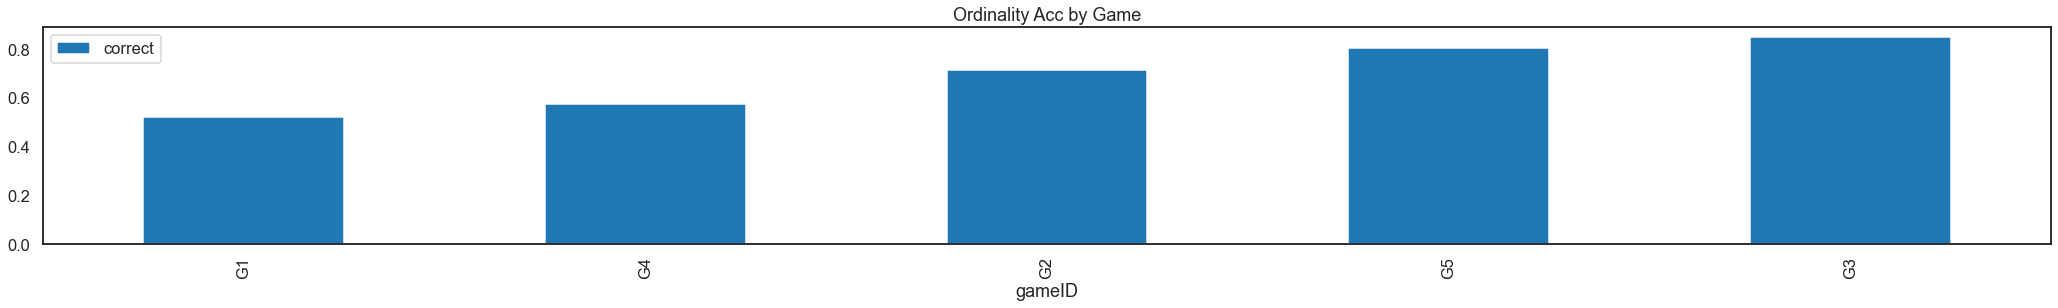

In [106]:
W[W['eventType']=='ordinality'].groupby('gameID')[['correct']].mean().sort_values('correct').plot.bar(figsize=(36,4))
plt.title("Ordinality Acc by Game")

# W[W['gameID']=='G1'][W['take']==0][W['eventType']=='quiz'][['cardinality']]#.plot.hist()

Text(0.5, 1.0, 'Accuracy by Game')

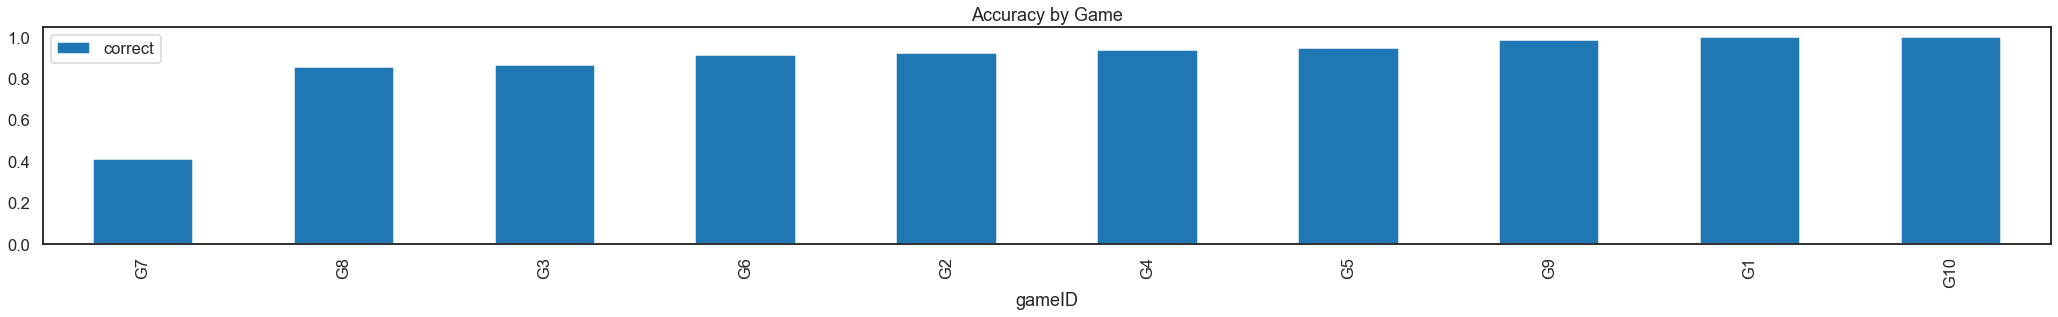

In [72]:
# What does accuracy look like in our games so far?
W.groupby('gameID')[['correct']].mean().sort_values('correct').plot.bar(figsize=(36,4))
plt.title("Accuracy by Game")

In [576]:
# what characters are supposed to be in the target lexicons of each participant?
temp = W[W['eventType'] == 'quiz'].groupby(['gameID'])[['target']].agg({"target":lambda x:
                                                                        x.str.cat()}).applymap(lambda x: set(x))

Text(0.5, 1.0, 'Distractions in each Game')

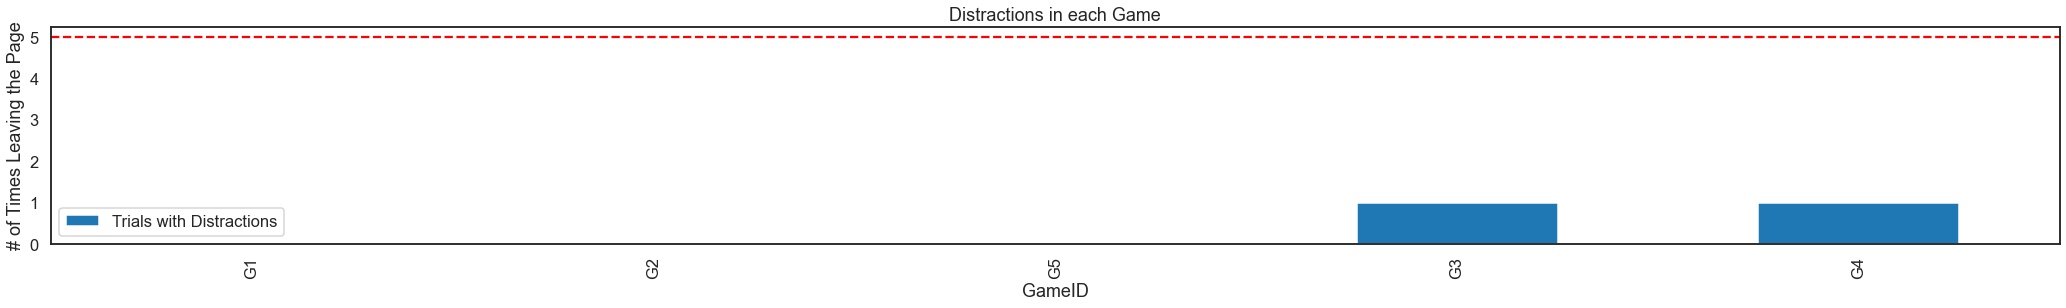

In [577]:
# how often were people 'distracted' by flipping between screens?
Wraw['distracted'] = Wraw[['distractions']].applymap(lambda x: 'blurred' in x.values()) # when did people leave the screen
distractedTrials = Wraw.groupby(['gameID','trialNum'])[['distracted']].agg({'distracted':lambda x: bool(sum(x))}) # identify distracted trials
distractedTrialFreq = distractedTrials.groupby(['gameID'])[['distracted']].sum().sort_values('distracted') # how often did each game have a trial with a distraction?
distractedTrialFreq = distractedTrialFreq.rename(columns={'distracted':'Trials with Distractions'})
distractedTrialFreq.plot.bar(figsize=(36,4))
plt.axhline(5,c='r',ls='--')
plt.xlabel("GameID")
plt.ylabel("# of Times Leaving the Page")
plt.title("Distractions in each Game")

## Excluding Games

In [14]:
# Before we start excluding, how many total games are there in each condition?
print("\033[1mHow many TOTAL games are there in each condition (valid or not)?\033[0m")
for b in Wraw.groupby(['base'])['gameID'].unique().index:
    print("Base {}: {} games".format(b,len(Wraw.groupby(['base'])['gameID'].unique()[b])))
print()

# How many total games with GENERALIZATION are there in each condition?
print("\033[1mHow many TOTAL games with GENERALIZATION are there in each condition (valid or not)?\033[0m")
for b in Wraw[Wraw['eventType'] == 'generalization'].groupby(['base'])['gameID'].unique().index:
    print("Base {}: {} games".format(b,len(Wraw[Wraw['eventType'] == 'generalization'].groupby(['base'])['gameID'].unique()[b])))
print()

print("\033[1mHow many in total then?\033[0m")
print("Total games: {} games".format(len(Wraw[Wraw['eventType'] == 'quiz'].gameID.unique())))
print("Games with generalization: {} games".format(len(Wraw[Wraw['eventType'] == 'generalization'].gameID.unique())))


How many TOTAL games are there in each condition (valid or not)?
Base 2: 16 games
Base 3: 16 games
Base 4: 19 games
Base 5: 18 games
Base 8: 39 games
Base 10: 44 games

How many TOTAL games with GENERALIZATION are there in each condition (valid or not)?
Base 2: 14 games
Base 3: 15 games
Base 4: 18 games
Base 5: 13 games
Base 8: 36 games
Base 10: 38 games

How many in total then?
Total games: 152 games
Games with generalization: 134 games


In [15]:
# Actual exclusions go in this cell

# tell whether on any given trial the person left the webpage for whatever reason
W['distracted'] = W[['distractions']].applymap(lambda x: 'blurred' in x.values()) # when did people leave the screen
distractedTrials = W.groupby(['gameID','trialNum'])[['distracted']].agg({'distracted':lambda x: bool(sum(x))}) # identify distracted trials
distractedTrialFreq = distractedTrials.groupby(['gameID'])[['distracted']].sum().sort_values('distracted') # how often did each game have a trial with a distraction?
distractedTrialGames = distractedTrialFreq[distractedTrialFreq['distracted'] > 6].index # set the cutoff point
# these two lines just take how many times in total they got distracted in the game - not grouped by trial
# distractedFreq = W.groupby(['gameID'])[['distracted']].sum().sort_values('distracted')
# distractedGames = distractedFreq[distractedFreq['distracted'] > 6].index
W['distractedGame'] = W['gameID'].isin(distractedTrialGames) # now create a column to tell us if it was a distracted game or not

# set up a little datastructure to use for excluding based on game accuracy (only look at people's first try)
temp = W[W['eventType'] == 'quiz'][W['take']==0].groupby('gameID').mean()[['correct']]

# identify games that were below absolute accuracy threshold
failedGames = temp[temp['correct'] < .5].index
W['failedGame'] = W['gameID'].isin(failedGames)

# identify games that were below relative accuracy threshold
cutoff = float(temp.mean() - np.std(temp)*3) # get cutoff
temp = temp[temp['correct'] < cutoff].index
W['failedOutlier'] = W['gameID'].isin(temp)

# make sure that we only keep complete games
complete = W.groupby('gameID')[['trialNum']].max() == 64
completeGames = complete[complete['trialNum'] == True].index
W['complete'] = W['gameID'].isin(completeGames)

# for if we only want to look at games with generalization trial
genGames = W[W['eventType'] == 'generalization']['gameID'].unique()
W['generalized'] = W['gameID'].isin(genGames)



# now identify games that used irrelevant characters in too many trials
# # bad way to do it because not everyone finished the generalization trial, but I don't want to delete cause it took forever
# gameChars = W[W['eventType'] == 'generalization'][["gameID","target"]].applymap(lambda x: # get a set of permissable letters per game  
#                                                                                 set(str(x).translate(
#                                                                                     str(x).maketrans(",[]'", "    "))) # exclude these
#                                                                                 if type(x)==list else x) # do it for target, not gameID     

# for each game, find all the characters that belong in the count list
gameChars = W[W['eventType'] == 'quiz'].groupby(['gameID'])[['target']].agg({"target":lambda x:
                                                                        x.str.cat()}).applymap(lambda x:
                                                                                               set(x).union(set(x.upper()).union(set(' '))))
# make it a searchable dictionary ({gameID : character_set})
gameCharDict = pd.Series(gameChars.target.values,index=gameChars.index).to_dict()

responseChars = W.groupby(['gameID','trialNum'])[['response']].agg({"response":lambda x:
                                                                    x.str.cat()}).applymap(lambda x:
                                                                                           set(x)).reset_index()    
responseChars['gameChars'] = responseChars[['gameID']].applymap(lambda x: gameCharDict[x])
responseChars['intersection'] = responseChars['response'] - responseChars['gameChars']
responseChars['intersection'] = responseChars[['intersection']].applymap(lambda x: bool(len(x)))
nonsenseFreq = responseChars.groupby('gameID')[['intersection']].sum() > 3
nonsenseGames = nonsenseFreq[nonsenseFreq['intersection'] == True].index
W['nonsenseGame'] = W['gameID'].isin(nonsenseGames)


# now filter all those games out - if you want to exclude based on generalization, do it here
W = W[W['failedOutlier'] == False][W['distractedGame'] == False][W['failedGame'] == False][W['complete'] == True][W['nonsenseGame'] == False]#[W['generalized'] == True]       

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [311]:
# How many valid games are there in each condition?
print("\033[1mHow many valid games are there in each condition?\033[0m")
for b in W.groupby(['base'])['gameID'].unique().index:
    print("Base {}: {} games".format(b,len(W.groupby(['base'])['gameID'].unique()[b])))
print()


# How many valid games with GENERALIZATION are there in each condition?
print("\033[1mHow many valid games with GENERALIZATION are there in each condition?\033[0m")
for b in W[W['eventType'] == 'generalization'].groupby(['base'])['gameID'].unique().index:
    print("Base {}: {} games".format(b,len(W[W['eventType'] == 'generalization'].groupby(['base'])['gameID'].unique()[b])))
print()


print("\033[1mHow many in total then?\033[0m")
print("Total games: {} games".format(len(W[W['eventType'] == 'quiz'].gameID.unique())))
print("Games with generalization: {} games".format(len(W[W['eventType'] == 'generalization'].gameID.unique())))


How many valid games are there in each condition?
Base 2: 12 games
Base 3: 12 games
Base 4: 15 games
Base 5: 12 games
Base 8: 33 games
Base 10: 33 games

How many valid games with GENERALIZATION are there in each condition?
Base 2: 11 games
Base 3: 12 games
Base 4: 15 games
Base 5: 8 games
Base 8: 30 games
Base 10: 30 games

How many in total then?
Total games: 117 games
Games with generalization: 106 games


In [17]:
if iteration == 'new':
    # G1 noseq; G2 shuffled; G3 ordered; G4 shuffled; G5 noseq
    map_by_hand = {'G1':'noseq',
                   'G2':'shuffled',
                   'G3':'control',
                   'G4':'shuffled',
                   'G5':'noseq'}
    W['condition'] = W['gameID'].apply(lambda x: map_by_hand[x])


In [324]:
# we're going to add something fun. For each number in each condition, we're going to add three columns telling us the following:
# namely, whether it (1) is a bare lexical primitive, (2) has additive merge, (3) multiplicative merge, (4) has an exponential multiplier (also a lexical primitive here)
# each column could be a binary vector, or count, (just 1 number has multiple instances of a rule type: 4-2-1 (seven) in base-2; possibly 8 too, as a 2nd order exp)
# but we'll add (5) the sum of (1-4) as a null hypothesis ("all rules and lexemes are equally easy")
# finally, probably in R, we'll store (6) the output of a polynomial that weights each of (1-4) with a 'difficulty coefficient'
# this 'difficulty coefficient' is really just the beta weights of (1-4) or (1-5*) in a regression predicting response time (or negative accuracy)
# haven't thought this through, but presumably (6) would be the best predictor in a regression (and redundant with (1-4))

# *one might expect an interaction, whereby rules are harder to recall/use when there are many of them at once (or easier, though that seems less likely)
# one last binary column, call it (0), could indicate whether there is ambiguity between two columns (under what prior?)
# bigrams are multiplicative if the left syllable has a smaller meaning, and additive if the right syllable has a smaller meaning, but this may be ambiguous to a stranger
# Later thought: maybe another column would be good counting how many distinct morphemes are in the word. Not syllable length, because e.g. 2-3-2 (eight) in base-3

# we will run this both for quiz trials in Exp1, and quiz + magnitude comparison trials in Exp2

# First, create a dictionary mapping every number in every base system to the correct vector: [prim,add,mult,exp,sum], though we add sum programmatically:
b2_features = {1:[1,0,0,0],2:[1,0,0,0],3:[0,1,0,0],4:[1,0,0,1],5:[0,1,0,1],6:[0,1,0,1],7:[0,1,0,1],8:[1,0,0,1],9:[0,1,0,1],10:[0,1,0,1]}
b3_features = {1:[1,0,0,0],2:[1,0,0,0],3:[1,0,0,0],4:[0,1,0,0],5:[0,1,0,0],6:[0,0,1,0],7:[0,1,1,0],8:[0,1,1,0],9:[1,0,0,1],10:[0,1,0,1]}
b4_features = {1:[1,0,0,0],2:[1,0,0,0],3:[1,0,0,0],4:[1,0,0,0],5:[0,1,0,0],6:[0,1,0,0],7:[0,1,0,0],8:[0,0,1,0],9:[0,1,1,0],10:[0,1,1,0]}
b5_features = {1:[1,0,0,0],2:[1,0,0,0],3:[1,0,0,0],4:[1,0,0,0],5:[1,0,0,0],6:[0,1,0,0],7:[0,1,0,0],8:[0,1,0,0],9:[0,1,0,0],10:[0,0,1,0]}
b8_features = {1:[1,0,0,0],2:[1,0,0,0],3:[1,0,0,0],4:[1,0,0,0],5:[1,0,0,0],6:[1,0,0,0],7:[1,0,0,0],8:[1,0,0,0],9:[0,1,0,0],10:[0,1,0,0]}
bT_features = {1:[1,0,0,0],2:[1,0,0,0],3:[1,0,0,0],4:[1,0,0,0],5:[1,0,0,0],6:[1,0,0,0],7:[1,0,0,0],8:[1,0,0,0],9:[1,0,0,0],10:[1,0,0,0]}

b_dicts = {2:b2_features, 3:b3_features, 4:b4_features, 5:b5_features, 8:b8_features, 10:bT_features} # based on base-condition in each row, know which dict to use

# toy = W.head(100)[['gameID','base','cardinality']]    # testing out first on something small

# now for each row, look up base and cardinality and assign the vector to the new columns
W[['prim','add','mult','exp']] = W.apply(lambda x: pd.Series(b_dicts[x['base']][x['cardinality']],
                                                             index=['prim','add','mult','exp']) if x['cardinality'] > 0 else pd.Series([np.nan]*4,
                                                                                                                                       index=['prim','add','mult','exp']),
                                         axis=1) # note, some cardinalities are np.nan (uh oh). None is == 0, so we'll catch NaNs on that basis (& let them propagate)
                                                 # realized why: generalization trials and surveys! I think a bug resulted in some double-surveys, too: 255 NaNs total
# here's that sum we were going to compute
W['feature_sum'] = W[['prim','add','mult','exp']].apply(lambda x: sum(x), axis=1)


In [325]:
# save out the cleaned datastructure to a .csv that we can also analyse in R
W.to_csv("numsynData_{}.csv".format(iteration))

# /////////////////////////////////////////////////////////////////////////////
# /////////////////////////////////////////////////////////////////////////////
# /////////////////////////////////////////////////////////////////////////////
# ----------------------------------------------------------------------
# Start From Here once you have Datastructure Saved

In [326]:
# iteration = 'new'

# load in the cleaned datastructure from the .csv
W = pd.read_csv("numsynData_{}.csv".format(iteration))



In [694]:
# a dictionary to explain all the columns of W
colExpl = {'_id' : "Mongo has an ID for every datapoint",
           'iterationName' : "What experiment are we in?",
           'eventType' : "What is the trial type?",
           'finalCount' : "",
           'gameID': "Unique for every game; anonymized with 'G' + a number",
           'workerID' : "Leftover from MTurk, not in use now",
           'assignmentID' : "Leftover from MTurk, not in use now",
           'hitID' : "Leftover from MTurk, not in use now",
           'prolificID' : "Prolific worker's ID - keep this classified",
           'studyID' : "Another Prolific parameter",
           'sessionID' : "Another Prolific parameter",
           'score' : "Current score as a string with dollar sign",
           'totalScore' : "Current score as a number",
           'trialNum' : "How many trials through the game are we here?",
           'sectionTrial' : "How many trials through the current count are we here?",
           'cardinality' : "What is the number we have counted up to?",
           'base' : "Size of the base system used in the current game",
           'target' : "What is the number-word expected as correct from this trial (contains hyphens)",
           'response' : "What did participant actually write here?",
           'correct' : "Was their response correct?",
           'take' : "How many tries are we on? Take of '0' means first try",
           'distractions' : "Has participant left the screen at any point in this trial (or take FIX THIS)?",
           'trialStartTime' : "Milliseconds since 1970 until the start of this trial",
           'takeStartTime' : "Milliseconds since 1970 until the start of this take",
           'trialTime' : "How long did this trial take?",
           'takeTime' : "How long did this take take?",
           'RT' : "How long did participant take from the presentation of stimulus until typing something",
           'WT' : "How long did participant spend writing their answer",
           'initTime' : "When did this whole game begin?",
           'endTime' : "When did this take end? For the final trial, this is the ending of the game",
           'gender' : "One of a few options; only present in survey results",
           'age' : "Integer; only present in survey results",
           'comments' : "Any string they typed; only present in survey results",
           'understood' : "Do participants think they understood the task? Only present in survey results",
           'totalLength' : "How long did the whole game take? Only present in survey results",
           'distracted' : "Did participant leave the screen on this take?",
           'distractedGame' : "Did participant in this whole game leave the screen too many times for our exclusion criteria?",
           'failedGame' : "Did participant of this game not meet our ABSOLUTE accuracy criterion?",
           'failedOutlier' : "Did participant of this game not meet our RELATIVE accuracy criterion?",
           'complete' : "Did participant of this game do all the trials?",
           'nonsenseGame' : "Did participant of this game use too many symbols that weren't in the count-list?"
          }

# Analyses

In [71]:
len(Q) - (10* len(Q.gameID.unique()))
Q_backup = Q

In [72]:
len(W[W['eventType']=='quiz'][W['take']!=0])

# Q.groupby(['gameID','cardinality']).apply(lambda x: print(x[['cardinality']].tail(-1)   ))


q = Q.groupby(['gameID','cardinality']).apply(lambda x:  x.tail(-1)   ).drop(['gameID','cardinality'],axis=1).reset_index().set_index('level_2')
q.index.rename('index')
q.head()
Q = q

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [518]:
# First, let's separate out each trial type so that we can analyse them separately
T = W[W['eventType']=='tutorial']
Q = W[W['eventType']=='quiz']
G = W[W['eventType']=='generalization']
S = W[W['eventType']=='survey']
if iteration == 'new':
    O = W[W['eventType']=='ordinality']
    O = O.astype({'RT':float})

Q = Q.astype({'RT':'float','WT':'float'})

Q['numSyls'] = Q.target.str.count('-')+1

# now record the cumulative frequency for the target cardinality in every quiz trial
temp = Q[['trialNum','gameID','cardinality']]
Q['frequency'] = temp.apply(lambda x: Q.loc[
    Q['trialNum'] < x['trialNum']].loc[
    Q['gameID']==x['gameID']].loc[
    Q['cardinality']==x['cardinality']]['cardinality'].count(),axis=1)

# add some new columns to the quiz trial df
Q['normedWT'] = (Q.WT / Q.response.str.len())
Q['RTLessWrite'] = Q['RT'] - Q['WT']
Q['RTLessNormedWrite'] = Q['RT'] - Q['normedWT']
Q['RTPlusNormedWrite'] = Q['RT'] + Q['normedWT']

In [519]:
# make a measure of efficiency
# our pre-registered time DV looks like this:
Q['timeDV'] = Q.RT + (Q.WT / Q.response.str.len())

# get rid of outliers
Q.loc[Q['timeDV'] > Q[Q['base']==3][['timeDV']].agg(['std'])['timeDV'][0]*3, 'timeDV'] = np.nan


# make our measure of efficiency
Q['efficiency'] = np.nan

for gameid in Q['gameID'].unique():
    if np.nanvar(Q[Q['gameID'] == gameid]['correct']) != 0:
        zScoreAcc = stats.zscore(Q[Q['gameID'] == gameid]['correct'],nan_policy='omit')
    else:
        zScoreAcc = np.zeros(len(Q[Q['gameID'] == gameid]['correct'])) # is this the right way to do this?
    
    zScoreDur = stats.zscore(Q[Q['gameID'] == gameid]['timeDV'],nan_policy='omit')
    efficiency = zScoreAcc - zScoreDur
    
    for trialnum in Q[Q['gameID']==gameid]['trialNum'].unique():
        curGame = Q.loc[Q['gameID'] == gameid]
        ind = curGame[curGame['trialNum'] == trialnum].index[0]
        Q['efficiency'][ind] = efficiency[ind] # efficiency[ind] used to be efficiency[int(trialnum-1)] (which incorrectly resets per game)
        # additionally, D.loc[:, ('efficiency', ind)] had originally been D['efficiency'][ind], which threw a warning but actually seemed to run faster
#         Q.loc[:, ('efficiency', ind)] = efficiency[ind]


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24:

In [520]:
Q.to_csv("datastructures/numsynQ1&2.csv")


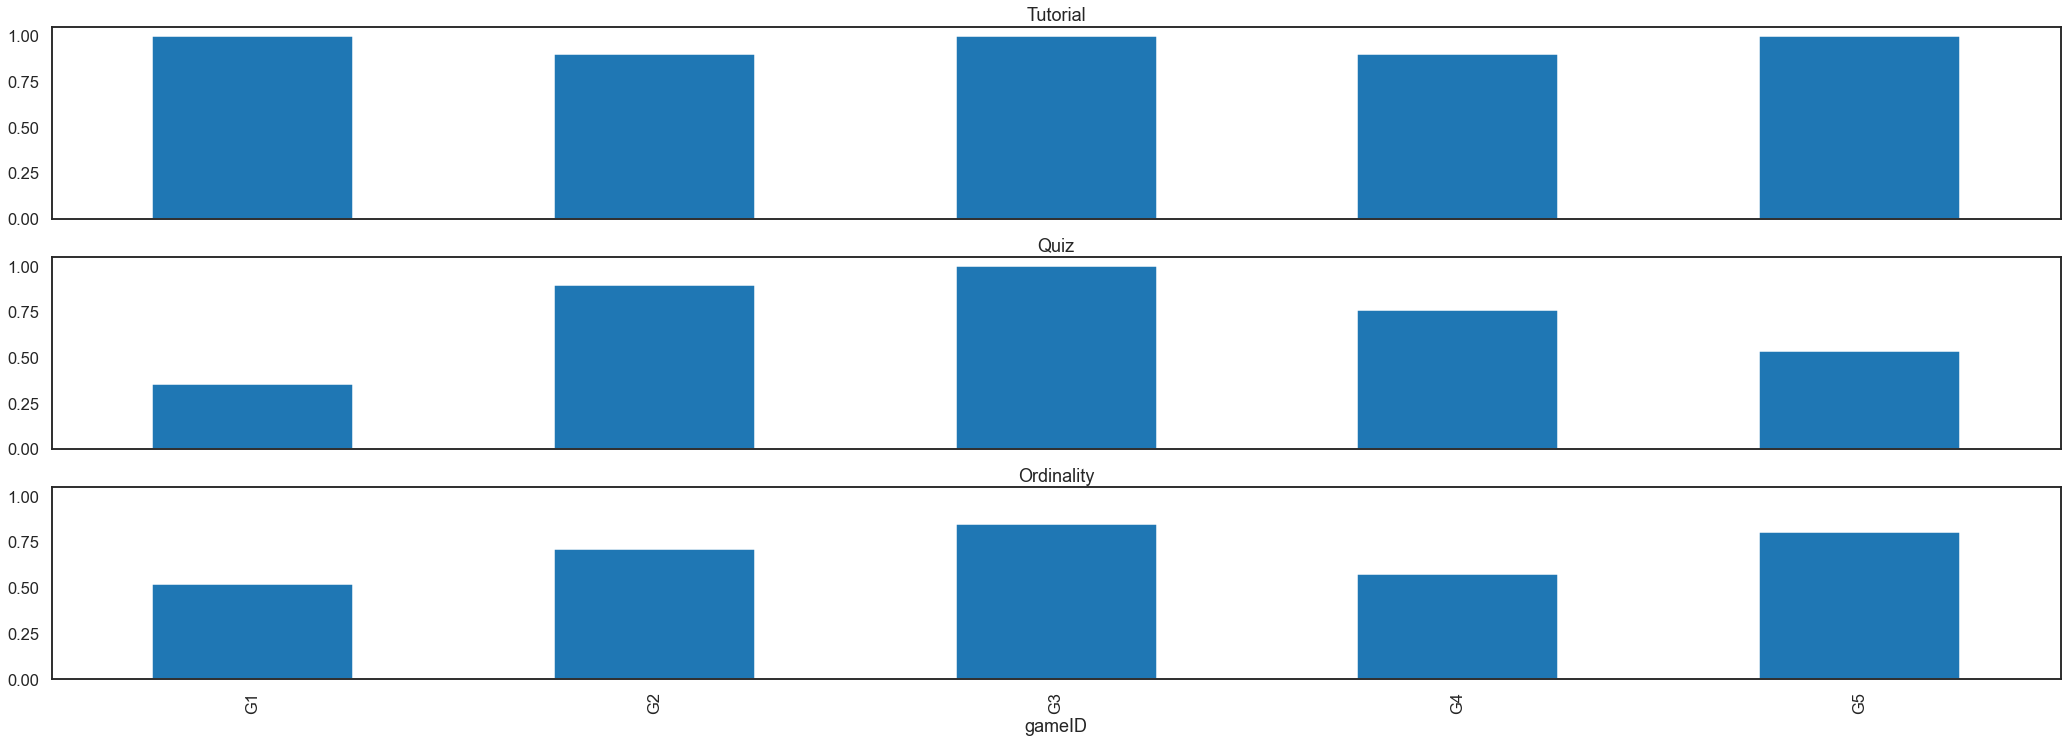

In [5]:
f , axs = plt.subplots(3,1,figsize=(36,12),sharex=True,sharey=True)

# T.groupby('gameID')[['correct']].mean().sort_values('correct').plot.bar(ax=axs[0],title='Tutorial',legend=False) # just in case you want to sort values

T.groupby('gameID')[['correct']].mean().plot.bar(ax=axs[0],title='Tutorial',legend=False)
Q.groupby('gameID')[['correct']].mean().plot.bar(ax=axs[1],title='Quiz',legend=False)
if iteration == 'new':
    O.groupby('gameID')[['correct']].mean().plot.bar(ax=axs[2],title='Ordinality',legend=False)  # only useful when there's ordinal trials to compare
# axs[2].axhline(y=.5,c='r',linestyle='--')

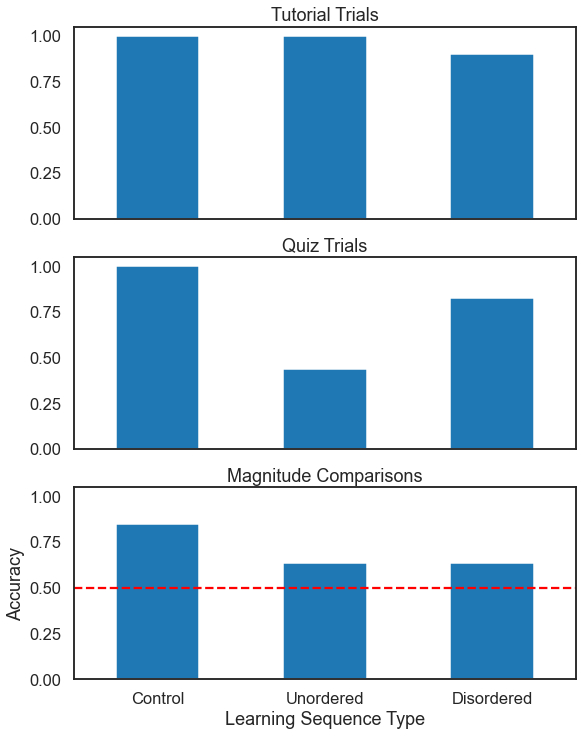

In [6]:
if iteration == 'new':
    f , axs = plt.subplots(3,1,figsize=(9,12),sharex=True,sharey=True)
    T.groupby(['condition'])[['correct']].mean().plot.bar(ax=axs[0],title='Tutorial Trials',legend=False)
    Q.groupby(['condition'])[['correct']].mean().plot.bar(ax=axs[1],title='Quiz Trials',legend=False)
    O.groupby(['condition'])[['correct']].mean().plot.bar(ax=axs[2],title='Magnitude Comparisons',legend=False)
    axs[2].axhline(y=.5,c='r',linestyle='--')
    axs[2].set_ylabel("Accuracy")
    axs[2].set_xlabel("Learning Sequence Type")
    axs[2].set_xticklabels(["Control","Unordered","Disordered"],rotation=0)

else:
    f , axs = plt.subplots(2,1,figsize=(9,8),sharex=True,sharey=True)
    T.groupby('base')[['correct']].mean().plot.bar(ax=axs[0],title='Tutorial',legend=False)
    Q.groupby('base')[['correct']].mean().plot.bar(ax=axs[1],title='Quiz',legend=False)


[Text(6.0, 0, '6'),
 Text(3.0, 0, '3'),
 Text(8.0, 0, '8'),
 Text(10.0, 0, '10'),
 Text(4.0, 0, '4'),
 Text(1.0, 0, '1'),
 Text(2.0, 0, '2'),
 Text(5.0, 0, '5'),
 Text(7.0, 0, '7'),
 Text(9.0, 0, '9')]

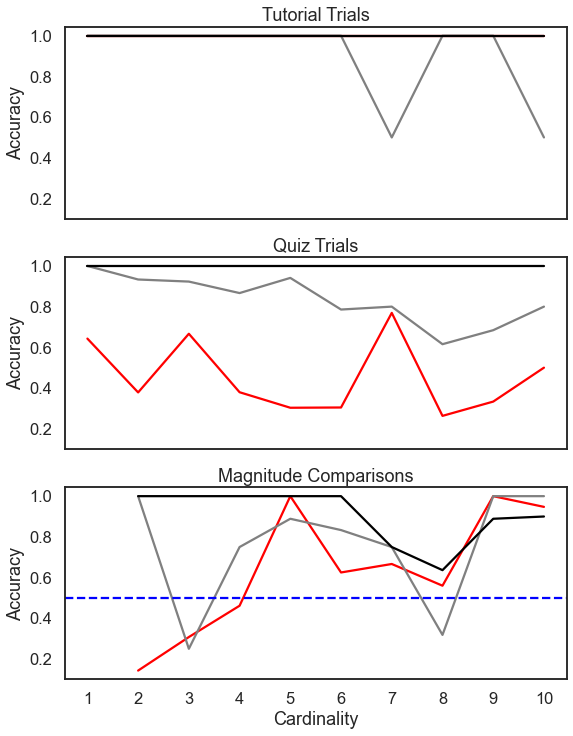

In [10]:
f , axs = plt.subplots(3,1,figsize=(9,12),sharex=True,sharey=True)

T[T['condition']=='noseq'   ].groupby(['cardinality'])[['correct']].mean().plot(ax=axs[0],title='Tutorial Trials',legend=False, c='red')
T[T['condition']=='shuffled'].groupby(['cardinality'])[['correct']].mean().plot(ax=axs[0],title='Tutorial Trials',legend=False, c='grey')
T[T['condition']=='control' ].groupby(['cardinality'])[['correct']].mean().plot(ax=axs[0],title='Tutorial Trials',legend=False, c='k')

Q[Q['condition']=='noseq'   ].groupby(['cardinality'])[['correct']].mean().plot(ax=axs[1],title='Quiz Trials',legend=False, c='red')
Q[Q['condition']=='shuffled'].groupby(['cardinality'])[['correct']].mean().plot(ax=axs[1],title='Quiz Trials',legend=False, c='grey')
Q[Q['condition']=='control' ].groupby(['cardinality'])[['correct']].mean().plot(ax=axs[1],title='Quiz Trials',legend=False, c='k')


O[O['condition']=='noseq'   ].groupby(['targetNum'])[['correct']].mean().plot(ax=axs[2],title='Magnitude Comparisons',legend=False, c='red')
O[O['condition']=='shuffled'].groupby(['targetNum'])[['correct']].mean().plot(ax=axs[2],title='Magnitude Comparisons',legend=False, c='grey')
O[O['condition']=='control' ].groupby(['targetNum'])[['correct']].mean().plot(ax=axs[2],title='Magnitude Comparisons',legend=False, c='k')

axs[0].set_ylabel("Accuracy")
axs[1].set_ylabel("Accuracy")
axs[2].set_ylabel("Accuracy")

axs[2].set_xlabel("Cardinality")
axs[2].set_xticks(Q.cardinality.unique())
axs[2].axhline(y=.5,c='b',linestyle='--')
axs[2].set_xticklabels(Q.cardinality.unique().astype(int),rotation=0)


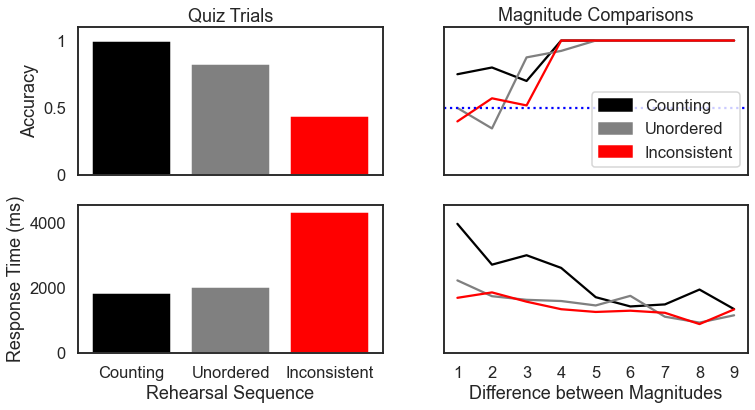

In [9]:

O['distractorNum'] = O[['responseNumber','otherNumber']].min(axis=1)
O['diff'] = O['targetNum'] - O['distractorNum']

f , ax = plt.subplots(2,2,figsize=(12,6),sharex='col', sharey='row')

ax[0,0].bar(x=['Counting','Unordered', 'Inconsistent'], height=[Q[Q['condition']=='control'][['correct']].mean()[0],
                                                                Q[Q['condition']=='shuffled'][['correct']].mean()[0],
                                                                Q[Q['condition']=='noseq'][['correct']].mean()[0]], color=['k','grey','r'])
ax[1,0].bar(x=['Counting','Unordered', 'Inconsistent'], height=[Q[Q['condition']=='control'][['RTPlusNormedWrite']].mean()[0],
                                                                Q[Q['condition']=='shuffled'][['RTPlusNormedWrite']].mean()[0],
                                                                Q[Q['condition']=='noseq'][['RTPlusNormedWrite']].mean()[0]], color=['k','grey','r'])
ax[0,0].set_title("Quiz Trials")
ax[1,0].set_xlabel("Rehearsal Sequence")


Q[Q['condition']=='control'][['correct']].mean()
# Q.groupby('condition')[['correct']].mean().plot.bar(ax=ax[0,0],title='Quiz Trials',color=['k','grey','r'])


O[O['condition']=='control'].groupby('diff')[['correct']].mean().plot(ax=ax[0,1],title='Magnitude Comparisons',c='k',label="Counting")
O[O['condition']=='shuffled'].groupby('diff')[['correct']].mean().plot(ax=ax[0,1],c='grey',label="Unordered")
O[O['condition']=='noseq'].groupby('diff')[['correct']].mean().plot(ax=ax[0,1],c='red',label="Inconsistent")

ax[0,1].set_ylim(0,1.1)
ax[0,1].set_yticks([0,.5,1])
ax[0,1].set_yticklabels([0,.5,1])
ax[0,1].axhline(y=.5,c='b',linestyle=':')


O[O['condition']=='control'].groupby('diff')[['RT']].mean().plot(ax=ax[1,1],c='k',legend=False)
O[O['condition']=='shuffled'].groupby('diff')[['RT']].mean().plot(ax=ax[1,1],c='grey',legend=False)
O[O['condition']=='noseq'].groupby('diff')[['RT']].mean().plot(ax=ax[1,1],c='red',legend=False)

ax[1,1].set_xlabel("Difference between Magnitudes")
ax[0,1].set_xticks(np.arange(1,10))
ax[0,1].set_xticklabels(np.arange(1,10),rotation=0)

ax[0,0].set_ylabel("Accuracy")
ax[1,0].set_ylabel("Response Time (ms)")


blk_patch = mpatches.Patch(color='k', label='Counting')
gry_patch = mpatches.Patch(color='grey', label='Unordered')
red_patch = mpatches.Patch(color='red', label='Inconsistent')

ax[0,1].legend(handles=[blk_patch, gry_patch, red_patch])



Done


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.29411765, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.45454545, 0.25      , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.41666667, 0.71428571, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.83333333, 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 1.        , 0.71428571, 1.        , 0.45454545,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 1.        , 1.        , 1.        , 0.41666667,
        0.5       , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 1.        , 1.       

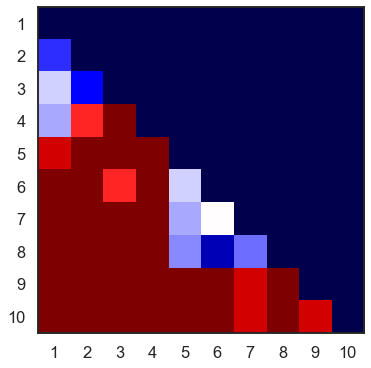

In [47]:
O['acc'] = O['targetNum'] == O['otherNumber']


# initialize matrix to be all the max and min numbers by all the max and min numbers
all_nums = len(np.arange(O.distractorNum.unique().min().astype(int),O.targetNum.unique().max().astype(int)+1))
acc_mat = np.zeros((all_nums,all_nums)) # how many times did they get it right?
try_mat = np.zeros((all_nums,all_nums)) # how many tries did people get?

rt_mat = np.zeros((all_nums,all_nums))

for trial in O[['targetNum', 'distractorNum', 'correct', 'RT']].iterrows():
    row = int(trial[1]['targetNum']) - 1
    col = int(trial[1]['distractorNum']) - 1
    acc = int(trial[1]['correct'])
    rt  = int(trial[1]['RT'])

    acc_mat[row,col] += acc
    try_mat[row,col] += 1
    rt_mat[row,col]  += rt



f , ax = plt.subplots(1,1,figsize=(6,6))
im = ax.imshow(np.nan_to_num(acc_mat / try_mat), cmap='seismic', interpolation='nearest')
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(np.arange(1,11))
ax.set_yticklabels(np.arange(1,11))
print("Done")


np.nan_to_num(acc_mat / try_mat)

In [45]:
# np.nan_to_num(acc_mat / try_mat)

acc_mat

O[O['targetNum'] == 8][O['distractorNum'] == 1][['correct']]

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


correct
30       1.0
124      1.0
160      1.0
239      1.0
317      1.0

In [7]:

O['syllDiff'] = O[['responseWord','otherWord']].apply(lambda x: abs(int((len(x['responseWord'].replace('-','')) - len(x['otherWord'].replace('-','')))/2)),
                                      axis=1)

In [8]:
# try to plot the above over trial number instead of just magnitude difference. See about switch costs to new task, and how quickly (if at all) they're overcome

# uncomment this line? I already can't remember
O = O.sort_values(['gameID','initTime']).reset_index().drop(['index', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)

def getTrial(x):
    y = x # copy it
    first_index = x.index[0] - 1
    
    for trial in x.index:
        y['trialNum'][trial] = trial - first_index
        
    return y['trialNum']

O['trialNum'] = O.groupby('gameID').apply(lambda x: getTrial(x)).reset_index()['trialNum']



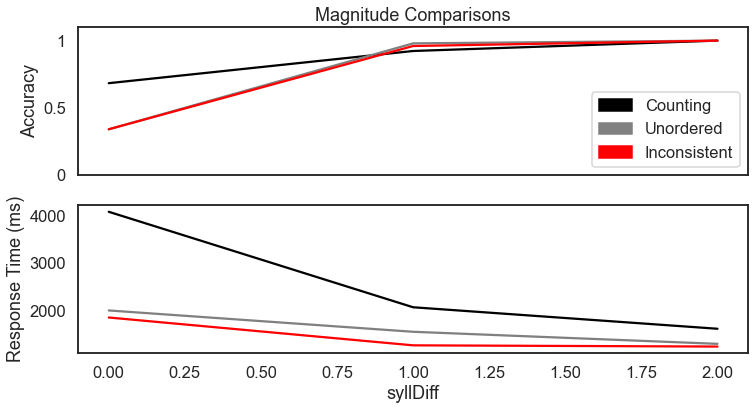

In [65]:
f , ax = plt.subplots(2,1,figsize=(12,6),sharex='col', sharey='row')

iv = 'syllDiff' # or maybe 'trialNum' or 

O[O['condition']=='control'].groupby(iv)[['correct']].mean().plot(ax=ax[0],title='Magnitude Comparisons',c='k',label="Counting")
O[O['condition']=='shuffled'].groupby(iv)[['correct']].mean().plot(ax=ax[0],c='grey',label="Unordered")
O[O['condition']=='noseq'].groupby(iv)[['correct']].mean().plot(ax=ax[0],c='red',label="Inconsistent")

ax[0].set_ylim(0,1.1)
ax[0].set_yticks([0,.5,1])
ax[0].set_yticklabels([0,.5,1])

O[O['condition']=='control'].groupby(iv)[['RT']].mean().plot(ax=ax[1],c='k',legend=False)
O[O['condition']=='shuffled'].groupby(iv)[['RT']].mean().plot(ax=ax[1],c='grey',legend=False)
O[O['condition']=='noseq'].groupby(iv)[['RT']].mean().plot(ax=ax[1],c='red',legend=False)

ax[1].set_xlabel(iv)
# ax[0].set_xticks(np.arange(1,10))
# ax[0].set_xticklabels(np.arange(1,10),rotation=0)

ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("Response Time (ms)")


blk_patch = mpatches.Patch(color='k', label='Counting')
gry_patch = mpatches.Patch(color='grey', label='Unordered')
red_patch = mpatches.Patch(color='red', label='Inconsistent')

ax[0].legend(handles=[blk_patch, gry_patch, red_patch])


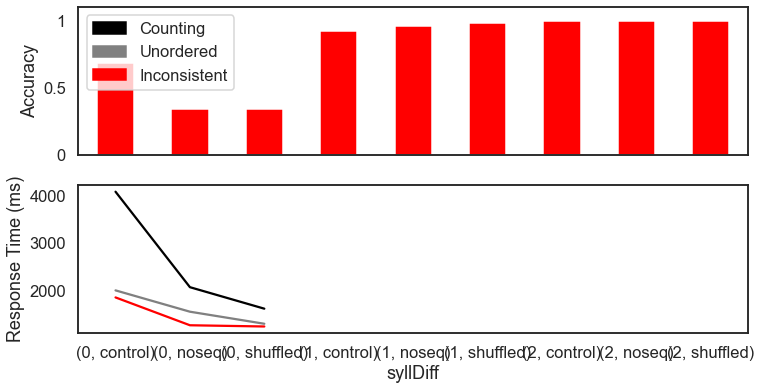

In [61]:
f , ax = plt.subplots(2,1,figsize=(12,6),sharex='col', sharey='row')

iv = 'syllDiff' # or maybe 'trialNum' or 

# O[O['condition']=='control'].groupby(iv)[['correct']].mean().plot.bar(ax=ax[0],title='Magnitude Comparisons',fill='k',label="Counting")
# O[O['condition']=='shuffled'].groupby(iv)[['correct']].mean().plot.bar(ax=ax[0],fill='grey',label="Unordered")
# O[O['condition']=='noseq'].groupby(iv)[['correct']].mean().plot.bar(ax=ax[0],fill='red',label="Inconsistent")
O.groupby(['syllDiff','condition'])[['correct']].mean().plot.bar(ax=ax[0],color=['red', 'blue', 'k'])

ax[0].set_ylim(0,1.1)
ax[0].set_yticks([0,.5,1])
ax[0].set_yticklabels([0,.5,1])

O[O['condition']=='control'].groupby(iv)[['RT']].mean().plot(ax=ax[1],c='k',legend=False)
O[O['condition']=='shuffled'].groupby(iv)[['RT']].mean().plot(ax=ax[1],c='grey',legend=False)
O[O['condition']=='noseq'].groupby(iv)[['RT']].mean().plot(ax=ax[1],c='red',legend=False)

ax[1].set_xlabel(iv)
# ax[0].set_xticks(np.arange(1,10))
# ax[0].set_xticklabels(np.arange(1,10),rotation=0)

ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("Response Time (ms)")


blk_patch = mpatches.Patch(color='k', label='Counting')
gry_patch = mpatches.Patch(color='grey', label='Unordered')
red_patch = mpatches.Patch(color='red', label='Inconsistent')

ax[0].legend(handles=[blk_patch, gry_patch, red_patch])


## Visualize the generalization phase

In [521]:
# What did people's generalizations look like? This is again more of a visualization
generalizations = W[W['eventType'] == 'generalization'].reset_index()['target']

G = pd.DataFrame(range(1,21),columns=['#'])
for j,g in enumerate(generalizations):
#     print("\033[1mGeneralization #{}\033[0m".format(j+1))
    gDF = pd.DataFrame(columns=['#',
                                'Targs{}'.format(j+1),
                                'Resps{}'.format(j+1),
                                'Base{}'.format(j+1),
                                'RT{}'.format(j+1),
#                                 'WT{}'.format(j+1)                                                  # WT only new
                               ])
    
    for i in range(15):
        # annoying thing: you have to literal_eval the target string to list...
        # & you have to interpret response string as json, when re-importing W from csv
        targ = ast.literal_eval(g)[i].replace("-","") if i < len(g) else "  "
        resp = json.loads(W[W['eventType'] == 'generalization'].reset_index(
            )['response'][j].replace("\'", "\""))[str(i+1)][0].replace("-","")
        
        rt = np.sum(json.loads(W[W['eventType'] == 'generalization'].reset_index(
            )['RT'][j].replace("\'", "\""))[str(i+1)])
#         wt = np.sum(json.loads(W[W['eventType'] == 'generalization'].reset_index(                       # WT only new
#             )['WT'][j].replace("\'", "\""))[str(i+1)])                                                  # WT only new
        
        base = W[W['eventType'] == 'generalization'].reset_index()['base'][j]
        newRow = pd.DataFrame([[i+1,targ,resp,base,rt,
#                                 wt                                                  # WT only new
                               ]], columns=gDF.columns)
        gDF = gDF.append(newRow)
    G = G.merge(gDF,on='#')

# # we could save this out, or just visualize it here:
G#.to_csv("Generalizations.csv")


#  Targs1  Resps1 Base1    RT1  Targs2  Resps2 Base2    RT2  Targs3  \
0    1      na      na     4   7059      ti      ti     5  21135      ne   
1    2      ki      ki     4   3279      nu      nu     5   2084      to   
2    3      tu      tu     4   1032      he      he     5  10422      ha   
3    4      se      se     4   1896      so      so     5    930      si   
4    5    sena    sena     4   1224      ka      ka     5    768      ku   
5    6    seki    seki     4   3121    kati    kati     5   1970    kune   
6    7    setu    setu     4   2480    kanu    kanu     5   1926    kuto   
7    8    kise    kise     4   1768    kahe    kahe     5   8966    kuha   
8    9  kisena  kisena     4   5376    kaso    kaso     5   2249    kusi   
9   10  kiseki  kiseki     4   4600    nuka    nuka     5   2355    toku   
10  11  kisetu  kisetu     4  15408  nukati  hekati     5  75304  tokune   
11  12    tuse    tuna     4   7624  nukanu  nukati     5   3810  tokuto   
12  13  tusena  tunaki     4  43714  nukahe      hj     5   8917  tokuha   
13  14  tuseki  tunatu     4   6112  nukaso  nukanu     5   4646  tokusi   
14  15  tusetu  tunase     4  22296    heka    heka     5   7743    haku   

   Resps3 Base3    RT3    Targs4    Resps4 Base4    RT4  Targs5  Resps5 Base5  \
0      ne     5   7793        no        no     2  11221      ho      ho     5   
1      to     5   4255        ta        ta     2   7076      ne      ne     5   
2      ha     5   3289      tano      tano     2   2492      ki      ki     5   
3      si     5   2444        hi        hi     2   2958      su      su     5   
4      ku     5   5824      hino      hino     2   2351      ta      ta     5   
5    kune     5   2539      hita      hita     2   3814    taho    taho     5   
6    kuto     5   3496    hitano    hitano     2   2080    tane    tane     5   
7    kuha     5   3576        su        su     2   4697    taki    taki     5   
8    kusi     5   2248      suno      suno     2   3588    tasu    tasu     5   
9    toku     5   9067      suta      suta     2  11151    neta    neta     5   
10   nene     5  11230    sutano    sutano     2   6894  netaho  netaho     5   
11   neto     5   3297      suhi      suhi     2   8759  netane  netane     5   
12   neha     5   5387    suhino    suhino     2  14348  netaki  netaki     5   
13   nesi     5   6776    suhita    sutahi     2   8893  netasu  netasu     5   
14   neku     5   3883  suhitano  sutahino     2   8725    kita  netata     5   

      RT5  Targs6    Resps6 Base6    RT6    Targs7  Resps7 Base7     RT7  \
0   50522      sa        sa     4  10062        te      te     2  204537   
1    5568      ke        ke     4   4957        ki      ki     2   53394   
2    3617      ho        ho     4   7722      kite    kite     2    1187   
3    3808      tu        tu     4   4286        hu      hu     2    1649   
4    3840    tusa      tusa     4   3318      hute    hute     2     509   
5    8783    tuke      ketu     4  36835      huki    huki     2     688   
6    4753    tuho      tuho     4  36606    hukite  hukite     2    1640   
7    7504    ketu      ketu     4  10282        na      na     2     990   
8    8944  ketusa    ketusa     4   3644      nate    nate     2     945   
9    7376  ketuke    ketuke     4   6889      naki    naki     2    2377   
10  27151  ketuho    ketuho     4  25121    nakite  nakite     2    6290   
11  69233    hotu    ketutu     4  12925      nahu  nakiki     2    8561   
12  14255  hotusa  ketutusa     4  35490    nahute  nakite     2    7047   
13   9840  hotuke  ketutuke     4   4826    nahuki  nakihu     2    9240   
14  10784  hotuho  ketutuho     4   6024  nahukite  nakute     2    3003   

      Targs8    Resps8 Base8    RT8  Targs9    Resps9 Base9     RT9 Targs10  \
0         ke        ke     2  87973      nu        nu     4   18100      he   
1         so        so     2  14983      he        he     4    6262      ni   
2       soke      soke     2  67515  

## Now make a DF of the generalization phase that's useful

In [21]:
G = W[W['eventType']=='generalization']


In [530]:
# decide if we want large bases (which also go up to 20 in generalization) or everything (only up to 15)
high_generalization = True

# What did people's generalizations look like? This is again more of a visualization
generalizations = W[W['eventType'] == 'generalization'].reset_index()[['gameID','target','base']]

# how high do we want to trace the generalization performance?
highest_number = 15 if high_generalization == False else 20 
bases = [2,3,4,5,8,10]
    

G = pd.DataFrame(range(0),columns=['num'])

for j,g in enumerate(generalizations['target']):
#     print("\033[1mGeneralization #{}\033[0m".format(j+1))
    gDF = pd.DataFrame(columns=['GID','num','targ','resp','base','RT',
#                                 'WT','cond'                                                           # WT only new
                               ])
    GID = generalizations['gameID'][j]
    
    for i in range(highest_number):
        # annoying thing: you have to literal_eval the target string to list...
        # & you have to interpret response string as json, when re-importing W from csv
        
        if str(i+1) in json.loads(W[W['eventType'] == 'generalization'].reset_index(
            )['response'][j].replace("\'", "\"")).keys():
        
            targ = ast.literal_eval(g)[i].replace("-","") if i < len(g) else "  "
            resp = json.loads(W[W['eventType'] == 'generalization'].reset_index(
                )['response'][j].replace("\'", "\""))[str(i+1)][0].replace("-","")
            rt = np.sum(json.loads(W[W['eventType'] == 'generalization'].reset_index(
                )['RT'][j].replace("\'", "\""))[str(i+1)])
#             wt = np.sum(json.loads(W[W['eventType'] == 'generalization'].reset_index(          # WT only new
#                 )['WT'][j].replace("\'", "\""))[str(i+1)])                                     # WT only new
#             cond = W[W['eventType'] == 'generalization'].reset_index()['condition'][j]         # cond only new
            base = W[W['eventType'] == 'generalization'].reset_index()['base'][j]
        else:
            targ = np.nan
            resp = np.NAN # just to make this != targ
            rt = np.nan
            wt = np.nan                                                                        # WT only new
            cond = np.nan
            base = W[W['eventType'] == 'generalization'].reset_index()['base'][j]
        
        
        newRow = pd.DataFrame([[GID,i+1,targ,resp,base,rt,
#                                 wt,cond                                                             # WT only new
                               ]], columns=gDF.columns)
        gDF = gDF.append(newRow)
    G = G.append(gDF)

# now set the index to be some nice integers
G = G.set_index(np.arange(len(G)))
    
# we could save this out, or just visualize it here:
G.to_csv("datastructures/Generalizations1_emergency.csv")

print("Done")

Done


In [557]:
g = pd.read_csv("datastructures/Generalizations1_emergency.csv")

units_dict = dict(g.groupby('GID').apply(lambda x : dict(zip([y for y in list(x['targ']) if len(str(y))==2],
                                                             [np.squeeze(x[x['targ']==z]['num']) for z in [y for y in list(x['targ']) if len(str(y))==2]] ))))
g['units'] = g['GID'].apply(lambda x: units_dict[x] ) # now add that list to every generalization phase trial

def gloss(string,system):
    st = string if type(string)==str else " " # if it's a nan, then forget about it
    for entry in system:
        char_gloss = "-"+str(system[entry])+"-"
        st = st.replace(entry,char_gloss) # replace number word in string (entry) with Arabic gloss (system[entry])
        st = st.replace("--","-")
        st = st.replace("- -","-")
        st = st[:-1] if st.endswith('-') else st
        st = st[1: ] if st.startswith('-') else st
    return st

g['gloss'] = g.apply(lambda x: gloss(x['resp'],x['units']),axis=1)

# look at strategies by base-number:
g.loc[g['base']==4].loc[g['num']==12]['gloss'].value_counts()


2-4-4      4
3-4        2
3-4-2      1
2-4-2      1
1-2-4      1
3-1-2-4    1
2-4-3      1
1-2-4-1    1
2-4-1      1
3-1        1
3-4-1      1
Name: gloss, dtype: int64

In [558]:
g = pd.read_csv("datastructures/Generalizations1.csv")
g = g.drop(labels=["Unnamed: 0"],axis=1)



# first let's gloss all the responses that people have given (take number words and map to arabic numerals; there will be some nonsense syllables left over)

units_dict = dict(g.groupby('GID').apply(lambda x : dict(zip([y for y in list(x['Targs']) if len(y)==2],
                                                             [np.squeeze(x[x['Targs']==z]['num']) for z in [y for y in list(x['Targs']) if len(y)==2]] ))))
g['units'] = g['GID'].apply(lambda x: units_dict[x] ) # now add that list to every generalization phase trial

def gloss(string,system):
    st = string if type(string)==str else " " # if it's a nan, then forget about it
    for entry in system:
        char_gloss = "-"+str(system[entry])+"-"
        st = st.replace(entry,char_gloss) # replace number word in string (entry) with Arabic gloss (system[entry])
        st = st.replace("--","-")
        st = st.replace("- -","-")
        st = st[:-1] if st.endswith('-') else st
        st = st[1: ] if st.startswith('-') else st
    return st

g['gloss'] = g.apply(lambda x: gloss(x['Resps'],x['units']),axis=1)
g['new'] = g['num'] > 10  # is this a number we haven't seen before?

g.head()



num GID Targs Resps  Base      RT                                 units  \
0    1  G5    na    na     4  7059.0  {'na': 1, 'ki': 2, 'tu': 3, 'se': 4}   
1    2  G5    ki    ki     4  3279.0  {'na': 1, 'ki': 2, 'tu': 3, 'se': 4}   
2    3  G5    tu    tu     4  1032.0  {'na': 1, 'ki': 2, 'tu': 3, 'se': 4}   
3    4  G5    se    se     4  1896.0  {'na': 1, 'ki': 2, 'tu': 3, 'se': 4}   
4    5  G5  sena  sena     4  1224.0  {'na': 1, 'ki': 2, 'tu': 3, 'se': 4}   

  gloss    new  
0     1  False  
1     2  False  
2     3  False  
3     4  False  
4   4-1  False

(0.0, 1.0)

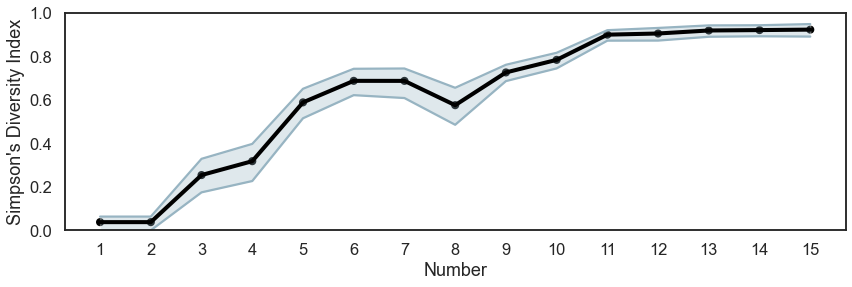

In [559]:
classification = 'num' # 'Base' or 'num', or another distinction

# get the estimate for Simpson's diversity index
simpsons = g.groupby([classification,'gloss'])[['gloss']].count(
).groupby(classification)[['gloss']].apply(
    lambda x: 1 - (sum([y*(y-1) for y in list(x['gloss'])]) / 
    (x['gloss'].sum()*(x['gloss'].sum() - 1))))

simpsons.name = "Simpson's Diversity Index"



# now bootstrap some uncertainty around that measure
subset_sims = np.zeros([len(g[classification].unique()),0])

for i in range(500):
    np.random.seed(i)
    subset_games = np.random.choice(g.GID.unique(), len(g.GID.unique()), replace=True)
    subset_g = g[g['GID'].apply(lambda x: x in subset_games)]
    cur_sim = np.array(subset_g.groupby([classification,'gloss'])[['gloss']].count(
    ).groupby(classification)[['gloss']].apply(
        lambda x: 1 - (sum([y*(y-1) for y in list(x['gloss'])]) / 
                       (x['gloss'].sum()*(x['gloss'].sum() - 1)))))
    
    subset_sims = np.append(subset_sims,np.array([cur_sim]).T,axis=1)

upperCI = np.quantile(subset_sims, .975, axis=1, keepdims = True, interpolation = 'nearest') # can't use 'method' because my python is outdated
lowerCI = np.quantile(subset_sims, .025, axis=1, keepdims = True, interpolation = 'nearest') # can't use 'method' because my python is outdated
upperCI = pd.DataFrame(np.squeeze(upperCI), columns=['upper']).reset_index().rename(columns={'index':classification})
lowerCI = pd.DataFrame(np.squeeze(lowerCI), columns=['lower']).reset_index().rename(columns={'index':classification})


f , ax1 = plt.subplots(1,1,figsize=(14,4))
temp = pd.DataFrame(simpsons).reset_index()
sns.pointplot(data=temp, x=classification, y="Simpson's Diversity Index",color='k',markers='.',ax=ax1)
sns.lineplot(data=upperCI, x=classification, y='upper',color='#97b4c2',ax=ax1)
sns.lineplot(data=lowerCI, x=classification, y='lower',color='#97b4c2',ax=ax1)
ax1.fill_between(upperCI[classification], lowerCI['lower'], upperCI['upper'], facecolor="#97b4c2", alpha=.3)
ax1.set_xlabel("Number")
ax1.set_ylim([0,1])

Working on base 2
Working on base 3
Working on base 4
Working on base 5
Working on base 8
Working on base 10


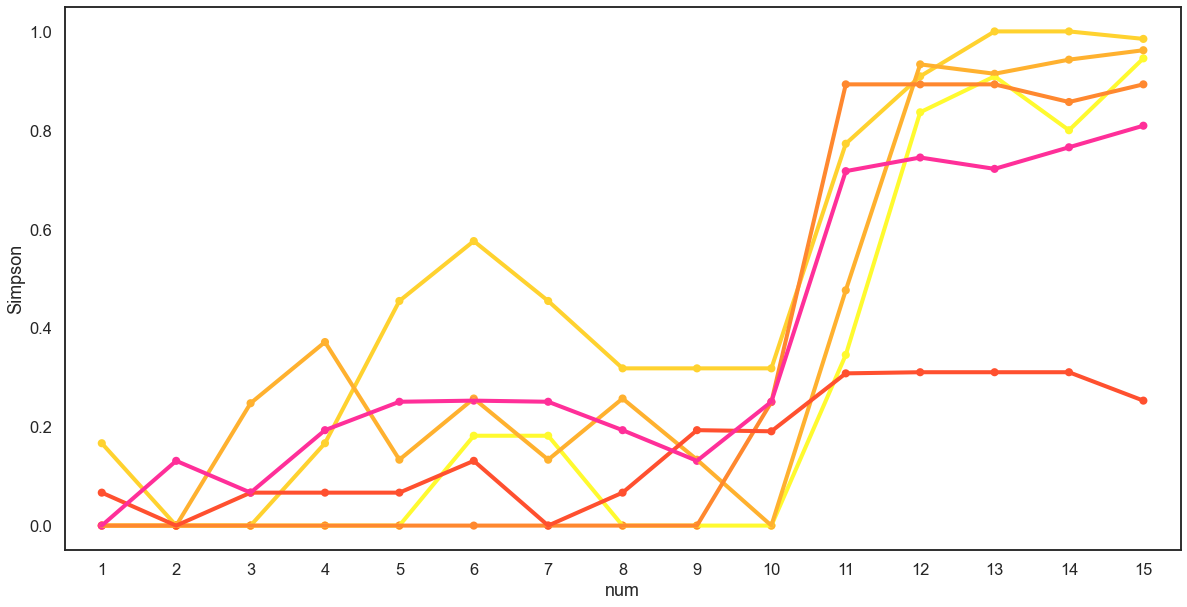

In [560]:
f , ax1 = plt.subplots(1,1,figsize=(20,10))

base_colours = ['#FFFA2F', '#FFD22F', '#FFB12F', '#FF882F', '#FF502F', '#FF2F99']

b_s = {} # base_simpsons, but short name

for j,base in enumerate([2,3,4,5,8,10]):
    print("Working on base {}".format(base))
    gb = g[g['Base']==base]
    
    classification = 'num' # could crumble the cookie in a different way though, like 10-15 vs 16-20, or based on whether an exponential rule is needed, etc

    # get the estimate for Simpson's diversity index
    simpsons = gb.groupby([classification,'gloss'])[['gloss']].count(
    ).groupby(classification)[['gloss']].apply(
        lambda x: 1 - (sum([y*(y-1) for y in list(x['gloss'])]) / 
        (x['gloss'].sum()*(x['gloss'].sum() - 1))))

    simpsons.name = 'Simpson'



    # now bootstrap some uncertainty around that measure
    subset_sims = np.zeros([len(gb[classification].unique()),0])

    for i in range(500):
        np.random.seed(i)
        subset_games = np.random.choice(gb.GID.unique(), len(gb.GID.unique()), replace=True)
        subset_gb = gb[gb['GID'].apply(lambda x: x in subset_games)]
        cur_sim = np.array(subset_gb.groupby([classification,'gloss'])[['gloss']].count(
        ).groupby(classification)[['gloss']].apply(
            lambda x: 1 - (sum([y*(y-1) for y in list(x['gloss'])]) / 
                           (x['gloss'].sum()*(x['gloss'].sum() - 1)))))

        subset_sims = np.append(subset_sims,np.array([cur_sim]).T,axis=1)

    upperCI = np.quantile(subset_sims, .975, axis=1, keepdims = True, interpolation = 'nearest') # can't use 'method' because my python is outdated
    lowerCI = np.quantile(subset_sims, .025, axis=1, keepdims = True, interpolation = 'nearest') # can't use 'method' because my python is outdated
    upperCI = pd.DataFrame(np.squeeze(upperCI), columns=['upper']).reset_index().rename(columns={'index':classification})
    lowerCI = pd.DataFrame(np.squeeze(lowerCI), columns=['lower']).reset_index().rename(columns={'index':classification})
    
    b_s[base] = subset_sims



    temp = pd.DataFrame(simpsons).reset_index()
    sns.pointplot(data=temp, x=classification, y='Simpson',color=base_colours[j],markers='.',ax=ax1)
#     sns.lineplot(data=upperCI, x=classification, y='upper',color='#97b4c2',ax=ax1)
#     sns.lineplot(data=lowerCI, x=classification, y='lower',color='#97b4c2',ax=ax1)
#     ax1.fill_between(upperCI[classification], lowerCI['lower'], upperCI['upper'], facecolor=base_colours[j], alpha=.5)


Text(0.5, 0, 'Base')

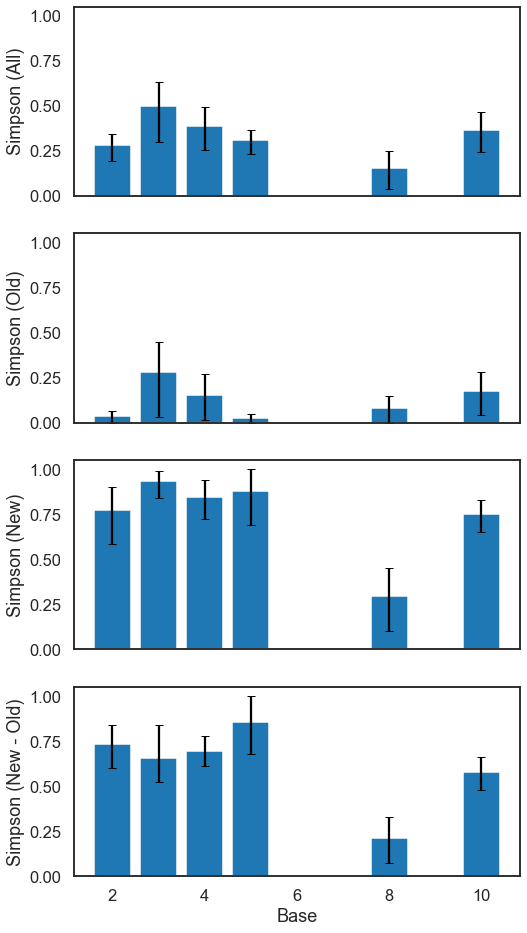

In [641]:
np.mean(b_s[2][10:15])

f , ((ax1,ax2,ax3,ax4)) = plt.subplots(4,1,figsize=(8,16), sharex=True, sharey=True)

def getUpperLower(sims):
    upperCI = np.squeeze(np.quantile(sims, .975, axis=1, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
    lowerCI = np.squeeze(np.quantile(sims, .025, axis=1, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
#     upperCI = pd.DataFrame(np.squeeze(upperCI), columns=['upper']).reset_index().rename(columns={'index':classification})
#     lowerCI = pd.DataFrame(np.squeeze(lowerCI), columns=['lower']).reset_index().rename(columns={'index':classification})
    return np.array([lowerCI,upperCI])

# average the Simpson's diversity estimates for every cardinality within each base, and get the measure of uncertainty for each
ax1.bar(x = [2,3,4,5,8,10], height=[np.mean(b_s[base]) for base in [2,3,4,5,8,10]],
        yerr=abs([np.mean(b_s[base]) for base in [2,3,4,5,8,10]] - np.array([np.mean(getUpperLower(b_s[base]),axis=1) for base in [2,3,4,5,8,10]]).T),
        capsize=4)
ax1.set_ylabel("Simpson (All)")

# average the Simpson's diversity estimates for LEARNED cardinalities within each base, and get the measure of uncertainty for each
ax2.bar(x = [2,3,4,5,8,10], height=[np.mean(b_s[base][0:10]) for base in [2,3,4,5,8,10]],
        yerr=abs([np.mean(b_s[base][0:10]) for base in [2,3,4,5,8,10]] - np.array([np.mean(getUpperLower(b_s[base][0:10]),axis=1) for base in [2,3,4,5,8,10]]).T),
        capsize=4)
ax2.set_ylabel("Simpson (Old)")

# average the Simpson's diversity estimates for NOVEL cardinalities within each base, and get the measure of uncertainty for each
ax3.bar(x = [2,3,4,5,8,10], height=[np.mean(b_s[base][10:15]) for base in [2,3,4,5,8,10]],
        yerr=abs([np.mean(b_s[base][10:15]) for base in [2,3,4,5,8,10]] - np.array([np.mean(getUpperLower(b_s[base][10:15]),axis=1) for base in [2,3,4,5,8,10]]).T),
        capsize=4)
ax3.set_ylabel("Simpson (New)")

# ax1.set_ylim(0,1)




def getUpperLower(sims):
    upperCI = np.squeeze(np.quantile(sims, .975, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
    lowerCI = np.squeeze(np.quantile(sims, .025, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
#     upperCI = pd.DataFrame(np.squeeze(upperCI), columns=['upper']).reset_index().rename(columns={'index':classification})
#     lowerCI = pd.DataFrame(np.squeeze(lowerCI), columns=['lower']).reset_index().rename(columns={'index':classification})
    return np.array([lowerCI,upperCI])


# average the Simpson's diversity estimates for difference between NOVEL & LEARNED cardinalities within each base, and get the measure of uncertainty for each
diffs = [np.mean(np.mean(b_s[base][10:15],axis=0) - np.mean(b_s[base][0:10],axis=0)) for base in [2,3,4,5,8,10]]
diffsCI = abs(diffs - np.array([getUpperLower(np.mean(b_s[base][10:15],axis=0) - np.mean(b_s[base][0:10],axis=0)) for base in [2,3,4,5,8,10]]).T)
ax4.bar(x = [2,3,4,5,8,10], height=diffs,
        yerr=diffsCI,
        capsize=4)
ax4.set_ylabel("Simpson (New - Old)")
ax4.set_xlabel("Base")



In [639]:
def getUpperLower(sims):
    upperCI = np.squeeze(np.quantile(sims, .975, axis=1, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
    lowerCI = np.squeeze(np.quantile(sims, .025, axis=1, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
#     upperCI = pd.DataFrame(np.squeeze(upperCI), columns=['upper']).reset_index().rename(columns={'index':classification})
#     lowerCI = pd.DataFrame(np.squeeze(lowerCI), columns=['lower']).reset_index().rename(columns={'index':classification})
    return np.array([lowerCI,upperCI])

[np.mean(b_s[base][10:15]) for base in [3,8]]
np.array([np.mean(getUpperLower(b_s[base][10:15]),axis=1) for base in [3,8]]).T

array([[0.83809524, 0.10421053],
       [0.99285714, 0.45414517]])

In [98]:
all_old = np.append(np.append(np.append(np.append(np.append(b_s[2],b_s[3],axis=1),b_s[4],axis=1),b_s[5],axis=1),b_s[8],axis=1),b_s[10],axis=1)[0:10]
all_new = np.append(np.append(np.append(np.append(np.append(b_s[2],b_s[3],axis=1),b_s[4],axis=1),b_s[5],axis=1),b_s[8],axis=1),b_s[10],axis=1)[10:15]

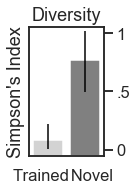

In [653]:
# cogsci_new

f , ax = plt.subplots(1,1,figsize=(2.5,3), sharex=True, sharey=True)

d = .5 # how dispersed should the scatter dots be? Depends on width of bars
fs = 12 # fontsize for text in the figure
lw = 1.5 # linewidth for the errorbars
cs = 0 # capsize for the errorbars
ew = 0 # edgewidth for the errorbars

# # average the Simpson's diversity estimates for difference between NOVEL & LEARNED cardinalities overall
# diffs = [np.mean(np.mean(all_new,axis=0) - np.mean(all_old,axis=0))]
# diffsCI = abs(diffs - np.array([getUpperLower(np.mean(all_new,axis=0) - np.mean(all_old,axis=0))]).T)
# ax.bar(x = [1], height=diffs,
#         yerr=diffsCI,
#         capsize=4)
# ax.set_ylabel("Simpson (New - Old)")
# ax.set_xlabel("Base")

# average the Simpson's diversity estimates for difference between NOVEL & LEARNED cardinalities overall
both = np.array([np.mean(all_old),np.mean(all_new)])
bothCI = np.array([getUpperLower(all_new) , getUpperLower(all_old)])
ax.bar(x = [0,1], height=both,
       yerr=abs(both - bothCI),
     #  edgecolor='k',
       fill=['lightgrey','grey'],color=['lightgrey','grey'],
       error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':lw})
ax.set_ylabel("Simpson's Index")
# ax.set_xlabel("Numbers")
ax.set_xticks([0,1])
ax.set_xticklabels(["Trained   ","   Novel"])
ax.set_ylim([0,1])
ax.set_title("Diversity")
plt.tight_layout()
ax.set_yticks([.05,.5,.95])
ax.set_yticklabels(['0','.5','1'])
ax.yaxis.tick_right()

f.savefig('../results/plots/cogsci23/Exp1simpsons.pdf', bbox_inches="tight")


# 95-CIs are relative? Something like that - this isn't right at the moment

In [554]:
bothCI

array([[0.19473684, 1.        ],
       [0.        , 0.52380952]])

# Bigram differences (post-hoc, totally null)

In [ ]:
# we're going to compare two estimates of diversity, cut along different lines
# One is the 'null' difference in diversity between labels within each base for all bigrams (N, N+1) (old & new numbers - doesn’t matter), averaged across bases
# Two is only the subset where N is last in a digit sequence and N+1 features a new instance of multiplication (or exp, which would catch a couple of cases)

In [445]:
# first, let's define some reference datastructures and functions that we'll use


# how does this mapping work? A number maps to 1 if it contains an instance of a multiplicative or exponential rule where the previous number did not, and 0 otherwise
AorM = {2  : {1:0, 2:0, 3:0, 4:1, 5:0, 6:0, 7:0, 8:1, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0},
        3  : {1:0, 2:0, 3:0, 4:0, 5:0, 6:1, 7:0, 8:0, 9:1, 10:0, 11:0, 12:0, 13:1, 14:0, 15:1},
        4  : {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:1, 9:0, 10:0, 11:0, 12:1, 13:0, 14:0, 15:0},
        5  : {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:1, 11:0, 12:0, 13:0, 14:0, 15:1},
        8  : {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:1, 17:0, 18:0, 19:0, 20:0},
        10 : {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0}}
# another version of the above dictionary (in fact, the one I had in mind originally) had 1's for everything to the right of the FIRST 1 (or first 1 past 10)
# though that actually wouldn't quite work with the code - then we wouldn't want bigrams, so much as... well, grouping

def getDiversity(tokns,measure='simpson'):
    """ Input is a list of strings. Measure can be either 'simpson' or 'shannon'.
    """
    if measure == 'simpson':
        token_counts = np.unique(tokns,return_counts=True) # now get counts for each token
        types = token_counts[0] # list all the types (an array of strings produced by participants)
        counts = token_counts[1] # the good stuff - this is the n in the formula
        N = len(tokns) # the other good stuff - this is the N in the formula
        diversity = 1 - (sum([y*(y-1) for y in counts]) / (N*(N-1)))
    return diversity

def getBigramType(b,num,divide="AorM"):
    """ By personal convention, 'num' is the larger of the two numbers in the bigram,
        If 'AorM', then only ask whether the bigram contains an instance of a multiplicative or exponential rule where the previous number did not
        If 'post_mult', then take any number in the count list past the first instance of a multiplicative rule.
        If 'post_10_mult', then take any number in the count list past the first instance of a multiplicative rule after 10.
    """
    if divide == 'AorM':
        baseDict = AorM[b]
        bigramType = baseDict[num]
#     if divide == 'post_mult':
#         bigramType = 
    return bigramType

In [446]:

# First, let's initialize the dataframe we want to fill with base-bigrams
BB = pd.DataFrame(columns=['base','n','n1','bigram_type','D_diff']) # prim, add, mult, exp

# Now, let's cycle through all the games
for base in g['Base'].unique():
    for n in g[g['Base']==base]['num'].unique(): # up to 15 or 20, in Exp1a & Exp1b, respectively
        if n != np.max(g[g['Base']==base]['num'].unique()): # only bother if it's not the last number, which we can't make a bigram out of

            tokens_n0 = list(g.loc[g['Base']==base].loc[g['num']==n]['gloss']) # list all tokens generated for this number:base (N=12 or 30 in Exp1a & Exp1b, respectively)
            tokens_n1 = list(g.loc[g['Base']==base].loc[g['num']==n+1]['gloss']) # list all tokens generated for the next number:base

            D_n0 = getDiversity(tokens_n0)    # get the diversity measure for labels of n across games within this base
            D_n1 = getDiversity(tokens_n1)    # get the diversity measure for labels of n + 1 across games within this base
            # N.B. we would want to permute here if we wanted an estimate that generalizaed over participants rather than base-bigrams

            bigram_diff = D_n1 - D_n0    # now take the difference in diversity in this bigram in this base
            bigram_type = getBigramType(base,n+1)    # is n -> n+1 a transition to a new multiplicative rule or not?

            newBigram = pd.DataFrame([[base,n,n+1,bigram_type,bigram_diff]], columns=BB.columns)
            BB = BB.append(newBigram)
    


In [447]:
print("All: {}\nA: {}\nM: {}".format(BB[['D_diff']].mean()[0],
                                     BB.loc[BB['bigram_type']==0][['D_diff']].mean()[0],
                                     BB.loc[BB['bigram_type']==1][['D_diff']].mean()[0]))

print("All: {}\nA: {}\nM: {}".format(len(BB['D_diff']),
                                     len(BB.loc[BB['bigram_type']==0]['D_diff']),
                                     len(BB.loc[BB['bigram_type']==1]['D_diff'])))


All: 0.054926197229152915
A: 0.050432194397711655
M: 0.08818181818181818
All: 84
A: 74
M: 10


In [482]:
# now we'll estimate the uncertainty by sampling a null distribution many times
permuted_diffs = np.zeros([0])

for i in range(500):
    np.random.seed(3*i)
    group0size = len(BB.loc[BB['bigram_type']==0]['D_diff'])
    group1size = len(BB.loc[BB['bigram_type']==1]['D_diff'])

    new_series = np.append([0]*group0size , [1]*group1size)
    np.random.shuffle(new_series)

    BB['shuffled_BT'] = new_series
    
    m0 = BB.loc[BB['bigram_type']==0][['shuffled_BT']].mean()[0]
    m1 = BB.loc[BB['bigram_type']==1][['shuffled_BT']].mean()[0]
    permuted_diffs = np.append(permuted_diffs,np.array(m1-m0))
    
    

In [489]:
toy = np.zeros([1,2])
toy = np.append(toy,np.ones([3,2]),axis=0)

toy = np.zeros([0])
toy = np.append(toy,np.ones([2]))
toy = np.append(toy,np.zeros([2]))

permuted_diffs.mean()

null_mu = permuted_diffs.mean()
null_upper = np.quantile(permuted_diffs, .975, interpolation = 'nearest')
null_lower = np.quantile(permuted_diffs, .025, interpolation = 'nearest')

measured = BB.loc[BB['bigram_type']==1][['D_diff']].mean()[0] - BB.loc[BB['bigram_type']==0][['D_diff']].mean()[0]

print("Est. mean = {},\n95% CI: [{} , {}]\nMeasured: {}".format(np.round(null_mu,5),
                                                               np.round(null_lower,5),
                                                               np.round(null_upper,5),
                                                               np.round(measured,5)) )

Est. mean = 0.00358,
95% CI: [-0.13514 , 0.20541]
Measured: 0.03775


### add some derived columns

In [370]:
# # add some derived columns

# G['new'] = G['num'] > 10  # is this a number we haven't seen before?

# # now get the expected units from the system they learned of    targets, get 0:base,     before the composed ones
# # units_dict = dict(G.groupby('GID').apply(lambda x :       list(x['targs'][0:x['base'].iat[0]])  )) # only units

# # this is the one that wasn't commented out:
# # units_dict = dict(G.groupby('GID').apply(lambda x :  [y for y in list(x['targ']) if len(y)==2] )) # this also captures bases, which are len(2)
# # G['units'] = G['GID'].apply(lambda x: units_dict[x] ) # now add that list to every generalization phase trial

# # see if the response given by participant is in the unit list (so only looking for atoms)
# # G.apply(lambda x: print(x['resps'] in x['units']), axis=1)







# # G[['count_diff','len_diff']] = G.apply(lambda x:
# #                                      pd.Series(parse(x['targ'],x['units']) - parse(x['resp'],x['units']),
# #                                                index=['count_diff', 'len_diff']),
# #                                      axis=1, result_type='expand')



# sys_dict = dict(G.groupby('GID').apply(lambda x : np.append(
#     np.array([np.arange(1,21)]),    np.array([[y for y in list(x['targ'])]]),   axis=0).transpose()#[:,19]
#                            ))
# G['system'] = G['GID'].apply(lambda x: sys_dict[x] ) # now add that list to every generalization phase trial
# G['gloss'] = G.apply(lambda x: gloss(x['resp'],x['system']),axis=1)
# G['exp_gloss'] = G.apply(lambda x: gloss(x['targ'],x['system']),axis=1)
# # G['condition'] = G['GID'].apply(lambda x: map_by_hand[x])   # only for 'pilot3_1' where we forgot to store condition; only new
# G['correct'] = G['resp'] == G['targ']

<AxesSubplot:>

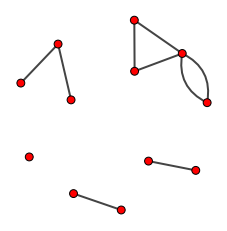

In [146]:

# W[W['gameID'] == 'G3'][W['trialNum'] < 10].sort_values(['gameID','trialNum'])[['condition','gameID','eventType','cardinality','target','response']]


# ACS
# Step 1: get set of n-grams from the target language (types)
# Step 2: get frequency of each (tokens) both in the system ('type-tokens') and in the training experience (tokens). Cornish et al 2017 use the latter
# Step 3: 


# Kamada Kawai: http://vis.pku.edu.cn/course/Visualization_2018F/reading/drawing_general_undirected.pdf

# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.kamada_kawai_layout.html
# temp = nx.path_graph(4)
# nx.kamada_kawai_layout(temp)

# https://igraph.org/python/tutorial/latest/visualisation.html
g = ig.Graph(edges=[[0, 1], [2, 3], [2, 4], [2, 4], [6, 5], [6, 7], [2, 8], [3, 8], [9, 11]])
# g.layout(layout='auto')
# ig.plot(g , layout="kamada_kawai")
fig, ax = plt.subplots()
ig.plot(g, target=ax, layout="kamada_kawai")


okay


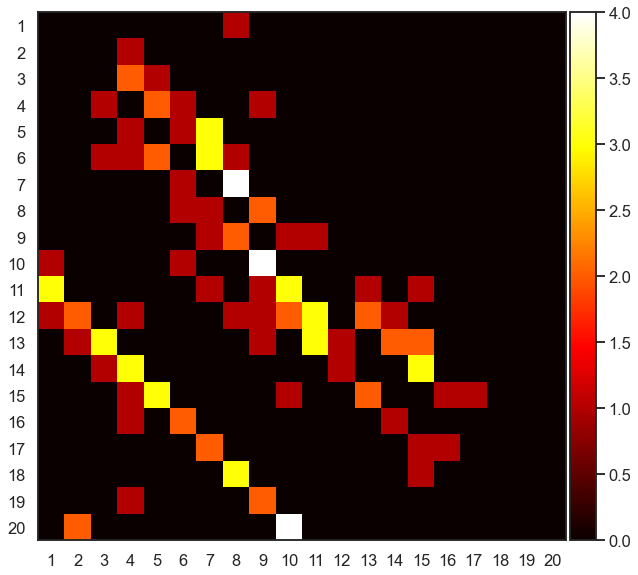

In [337]:
# Here, we want to make a heatmap of the times when people wrote one number but meant another

count_dict = dict(G.groupby('GID').apply(lambda x :  [y for y in list(x['targ'])] )) # this also captures bases, which are len(2)
G['countlist'] = G['GID'].apply(lambda x: count_dict[x] ) # now add that list to every generalization phase trial

# see if the response given by participant is in the count list (so only looking for atoms)
# G.apply(lambda x: print(x['resp'] in x['countlist']), axis=1)
G['confusion'] = G.apply(lambda x: x['countlist'].index(x['resp'])+1
                         if (x['resp'] in x['countlist'])     # only check if they accidentally gave a whole nother number
                         & (not x['correct'])                 # we are only interested in incorrect trials (ignore the diagonal)
                         & (type(x['resp']) == str)           # this excludes any np.nans around
                         else np.nan, axis=1)


def comp_confmat(actual, predicted):
    """ I just wanted to make a heatmap quickly, so I found one here:
    https://stackoverflow.com/questions/61193476/constructing-a-confusion-matrix-from-data-without-sklearn"""
    # extract the different classes
    classes = np.unique(actual)
    # initialize the confusion matrix
    confmat = np.zeros((len(classes), len(classes)))
    # loop across the different combinations of actual / predicted classes
    for i in range(len(classes)):
        for j in range(len(classes)):
           # count the number of instances in each combination of actual / predicted classes
           confmat[i, j] = np.sum((actual == classes[i]) & (predicted == classes[j]))
    return confmat

# G[['num','confusion']]

f , ax = plt.subplots(1,1,figsize=(10,10))

im = ax.imshow(comp_confmat(G['num'],G['confusion']), cmap='hot', interpolation='nearest')


from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

ax.set_xticks(np.arange(0,20))
ax.set_xticklabels(np.arange(1,21))

ax.set_yticks(np.arange(0,20))
ax.set_yticklabels(np.arange(1,21))

print("okay")
# number asked for is on the y-axis
# number given by subject on x-axis

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5, 0, 'Base')

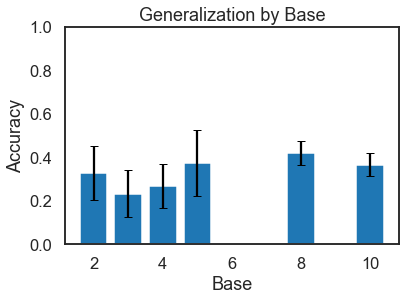

In [363]:

Ggen = G[G['targ'].apply(lambda x: type(x) != float)][G['new'] == True]

novels = Ggen.groupby(['base'])[['correct']].agg(('mean','count','std','var'))


# define any helpful functions here


dv = 'correct'

# plot accuracy over game condition, just the first take of each trial
fig , (ax1)= plt.subplots(1,1)

temp = get_confint(pd.DataFrame(Ggen.groupby(['base'])[['correct']].agg(['mean', 'count', 'std'])))

ax1.set_title("Generalization by Base")
ax1.bar(temp.reset_index()['base'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
        capsize=4)
ax1.set_ylim([0,1])
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Base")


In [430]:

def get_dists(g):
    
    num_games = len(g.GID.unique())
    gen_dists = np.zeros((num_games,num_games))
    

    for pos1,game1 in enumerate(g.GID.unique()):
        glosses1 = list(g[g['GID']==game1]['gloss'])

        for pos2,game2 in enumerate(g.GID.unique()):
            print("Game {} and Game {} of {} games total".format(pos1+1,pos2+1,num_games))
            clear_output(wait=True)
            
            dist = 0
    #         len(g[g['GID']==game1]) == len(g[g['GID']==game2])    # check to verify same number of gen trials
            glosses2 = list(g[g['GID']==game2]['gloss'])
            for row in range(len(glosses1)):
                dist += LD(glosses1[row],glosses2[row])

            gen_dists[pos1,pos2] = dist #now update the distance matrix
            
    return gen_dists



# all_dists = get_dists(G)
b2_dists = get_dists(G[G['base']==2])
b3_dists = get_dists(G[G['base']==3])
b4_dists = get_dists(G[G['base']==4])
b5_dists = get_dists(G[G['base']==4])
b8_dists = get_dists(G[G['base']==8])
bT_dists = get_dists(G[G['base']==10])

Game 30 and Game 30 of 30 games total


/Users/alles/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Constants 10 and 1.05 come from


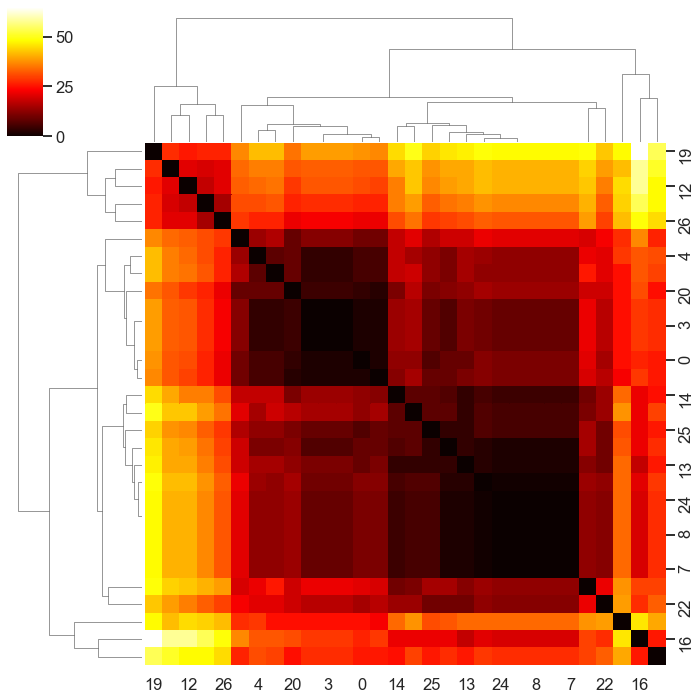

In [444]:
# f , ax = plt.subplots(1,1,figsize=(6,6))
# im = ax.imshow(get_dists(G[G['base']==4]), cmap='hot', interpolation='nearest')
# ax.set_xticks(np.arange(10))
# ax.set_yticks(np.arange(10))
# ax.set_xticklabels(np.arange(1,11))
# ax.set_yticklabels(np.arange(1,11))


a = sns.clustermap(bT_dists, cmap='hot')



In [422]:
G.groupby(['new'])[['correct']].agg(('mean','count','std','var'))


correct                          
           mean count       std       var
new                                      
False  0.931132  1060  0.253349  0.064186
True   0.285849  1060  0.452031  0.204332

Text(0.5, 0, 'Games')

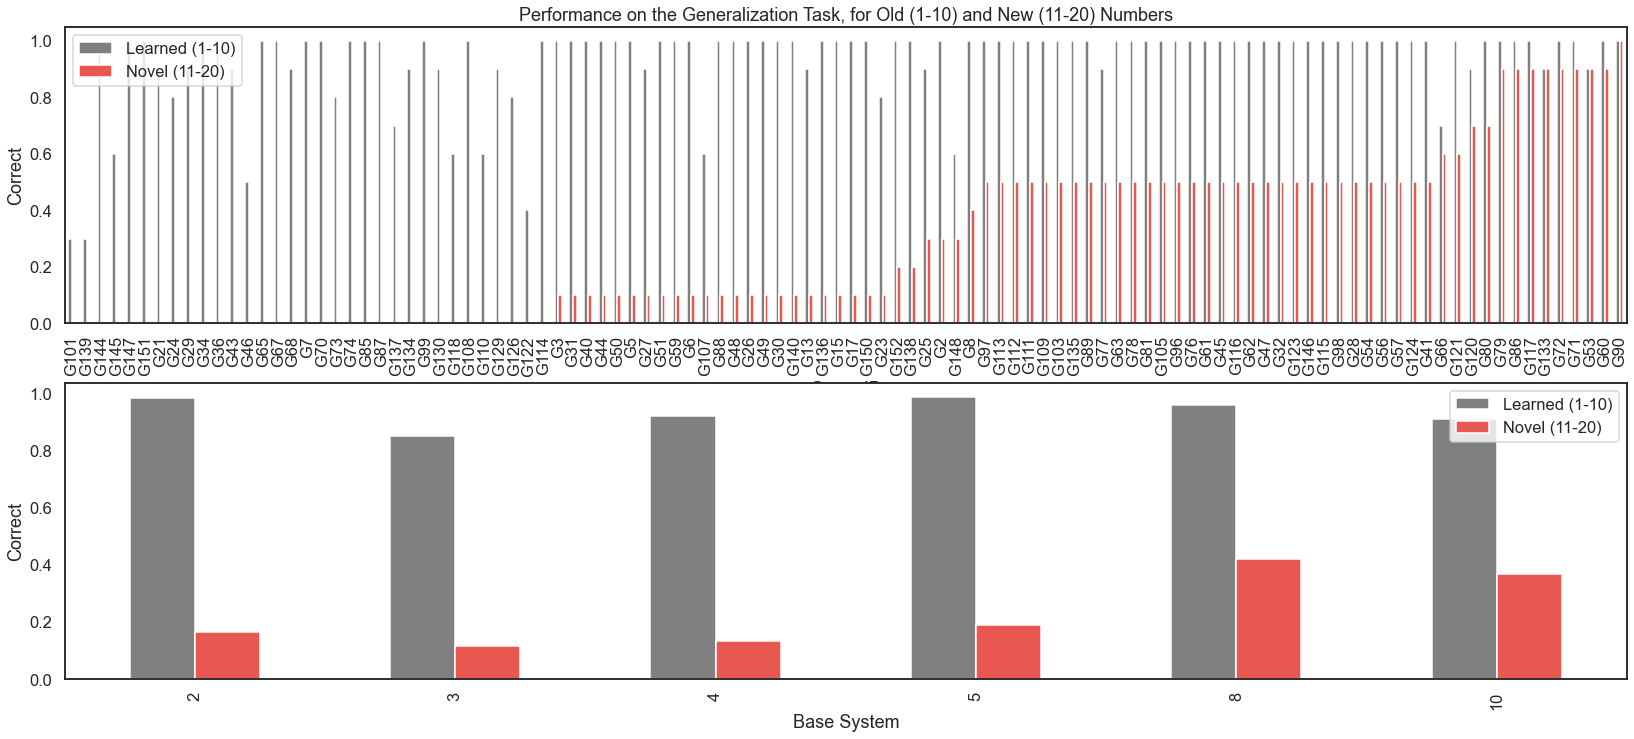

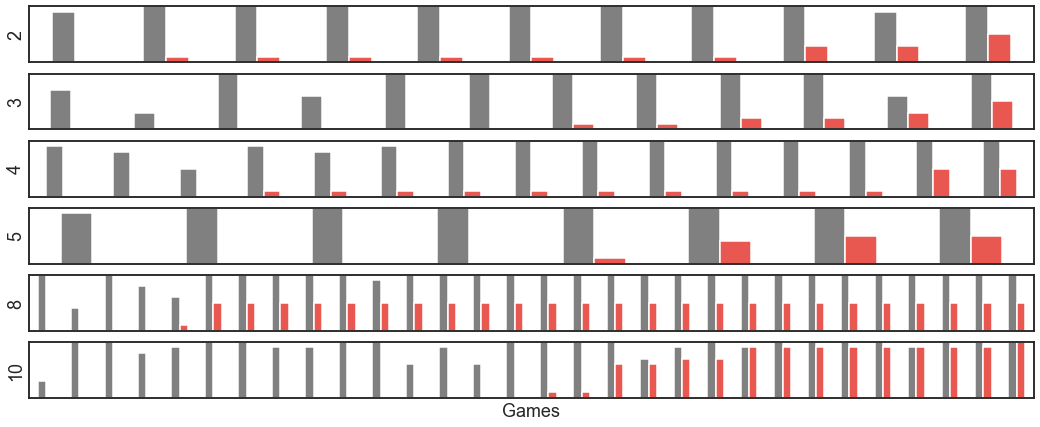

In [712]:
# see how people did separately in the old and new numbers during this phase
# observation: looks like there's a bi- or tri-modal pattern! Some people generalize, some people don't

oldnew_cols = ['gray','#E85750']

f , (ax1,ax2) = plt.subplots(2,1,figsize=(28,12))

G.groupby(['GID','new'])[['correct']].agg(('mean')).unstack().sort_values(('correct',True)).plot.bar(ax=ax1, color=oldnew_cols)
ax1.set_ylabel("Correct")
ax1.set_xlabel("Game ID")
ax1.legend(title="",labels=("Learned (1-10)","Novel (11-{})".format(highest_number)))
ax1.set_title("Performance on the Generalization Task, for Old (1-10) and New (11-{}) Numbers".format(highest_number))


# G.groupby(['base','new'])[['correct']].agg(('mean')).unstack().sort_values(('correct',True)).plot.bar(ax=ax2, color=oldnew_cols)
G.groupby(['base','new'])[['correct']].agg(('mean')).unstack().plot.bar(ax=ax2, color=oldnew_cols)
ax2.set_ylabel("Correct")
ax2.set_xlabel("Base System")
ax2.legend(title="",labels=("Learned (1-10)","Novel (11-{})".format(highest_number)))


f, axes = plt.subplots(len(bases),1,figsize=(18,1.2*len(bases)),sharey=True)
for i,b in enumerate(bases):
    G[G['base']==b].groupby(['GID','new'])[['correct']].agg(('mean')).unstack().sort_values(('correct',True)).plot.bar(ax=axes[i],
                                                                                                                       color=oldnew_cols)    
    axes[i].get_legend().remove()
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_ylim([0,1]) # want to make sure they all the same y-limit (maybe just do this in subplots)
    axes[i].set_ylabel("{}".format(b))
    axes[i].set_xlabel("")

axes[i].set_xlabel("Games")

In [332]:
# G[G['base']==8][G['num']>15]['correct'].mean()

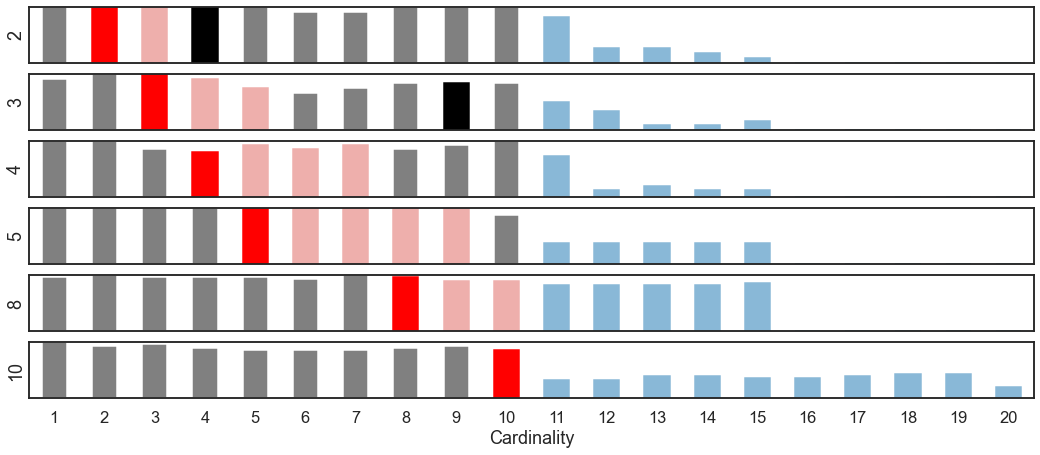

In [717]:
if iteration == 'old':
    f, axes = plt.subplots(len(bases),1,figsize=(18,1.2*len(bases)),sharey=True,sharex=True)
    for i,b in enumerate(bases):
        G[G['base']==b].groupby(['num'])[['correct']].mean().plot.bar(ax=axes[i],color='gray')    
        axes[i].get_legend().remove()
        axes[i].set_xticklabels(labels=np.arange(1,highest_number+1),rotation=0)
        axes[i].set_yticks([])
        axes[i].set_ylim([0,1]) # want to make sure they all the same y-limit (maybe just do this in subplots() )
        axes[i].set_ylabel("{}".format(b))
        axes[i].set_xlabel("")

        axes[i].get_children()[b-1].set_color('#FF0000')
        [axes[i].get_children()[b+j].set_color('#EEAFAC') for j in range(0,b-1)]

    #     axes[i].get_children()[b*2-1].set_color('#D86767') if b*2 < 21 else np.nan
    #     [axes[i].get_children()[b*2+j].set_color('brown') for j in range(0,b) if b*2 < 20]

        axes[i].get_children()[(b**2)-1].set_color('k') if b**2 < 20 else np.nan

        [axes[i].get_children()[10+j].set_color('#89B8D7') for j in range(0,10)]


    axes[i].set_xlabel("Cardinality")


else:
    conditions = ['noseq', 'shuffled', 'control']
    f, axes = plt.subplots(len(conditions),1,figsize=(18,1.2*len(conditions)),sharey=True,sharex=True)
    for i,c in enumerate(conditions):
        G[G['cond']==c].groupby(['num'])[['correct']].mean().plot.bar(ax=axes[i],color='gray')    
        axes[i].get_legend().remove()
        axes[i].set_xticklabels(labels=np.arange(1,highest_number+1),rotation=0)
        axes[i].set_yticks([])
        axes[i].set_ylim([0,1]) # want to make sure they all the same y-limit (maybe just do this in subplots() )
        axes[i].set_ylabel("{}".format(b))
        axes[i].set_xlabel("")

        axes[i].get_children()[b-1].set_color('#FF0000')
        [axes[i].get_children()[b+j].set_color('#EEAFAC') for j in range(0,b-1)]

    #     axes[i].get_children()[b*2-1].set_color('#D86767') if b*2 < 21 else np.nan
    #     [axes[i].get_children()[b*2+j].set_color('brown') for j in range(0,b) if b*2 < 20]

        axes[i].get_children()[(b**2)-1].set_color('k') if b**2 < 20 else np.nan

        [axes[i].get_children()[10+j].set_color('#89B8D7') for j in range(0,10)]


    axes[i].set_xlabel("Cardinality")



In [722]:
# G[G['base']==5][['base','GID','num','gloss','resp','targ','exp_gloss']]

# G13, G29, G30, G31

# G29 (cycle), G59 (calque), G26 (substring), G74 (freeze)
G[G['GID']=='G74'][['exp_gloss','gloss','resp','targ']]

exp_gloss    gloss      resp    targ
1140         1        1        hu      hu
1141         2        2        to      to
1142         3        3        ni      ni
1143         4        4        ka      ka
1144         5        5        ja      ja
1145         6        6        su      su
1146         7        7        gi      gi
1147         8        8        de      de
1148       8-1      8-1      dehu    dehu
1149       8-2      8-2      deto    deto
1150       8-3    8-2-1    detohu    deni
1151       8-4    8-2-2    detoto    deka
1152       8-5    8-2-3    detoni    deja
1153       8-6    8-2-4    detoka    desu
1154       8-7    8-2-5    detoja    degi
1155       2-8    8-2-6    detosu    tode
1156     2-8-1    8-2-7    detogi  todehu
1157     2-8-2    8-2-8    detode  todeto
1158     2-8-3  8-2-8-1  detodehu  todeni
1159     2-8-4  8-2-8-2  detodeto  todeka

In [635]:
G[G['base']==10][['base','GID','num','gloss','resp','targ','exp_gloss']]


In [361]:
# define any helpful functions here

def get_confint(df):
    """Takes a df already with columns ['Factors','mean','count','std']
    and gives a dataframe with confidence interval of high and low estimates"""
    new_df = df
    ci95_hi = []
    ci95_lo = []
    for i in new_df.index:
        m, c, s = new_df.loc[i]
        ci95_hi.append(m + 1.96*s/math.sqrt(c))
        ci95_lo.append(m - 1.96*s/math.sqrt(c))
    new_df['ci95_hi'] = ci95_hi
    new_df['ci95_lo'] = ci95_lo
    return new_df

Text(0.5, 0, 'Base')

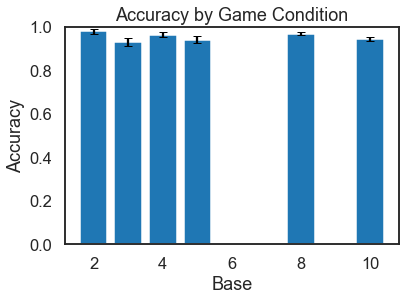

In [362]:
dv = 'correct'

# plot accuracy over game condition, just the first take of each trial
fig , (ax1)= plt.subplots(1,1)

temp = get_confint(pd.DataFrame(Q[Q['take']==0].groupby(['base'])[[dv]].agg(['mean', 'count', 'std'])))

ax1.set_title("Accuracy by Game Condition")
ax1.bar(temp.reset_index()['base'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
        capsize=4)
ax1.set_ylim([0,1])
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Base")

Text(0.5, 0, 'Base')

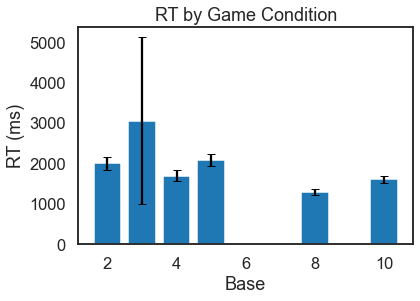

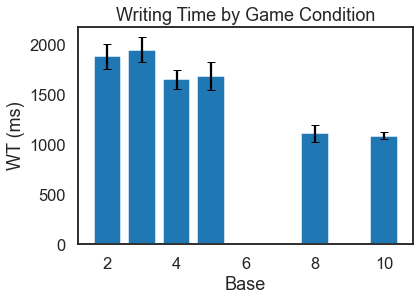

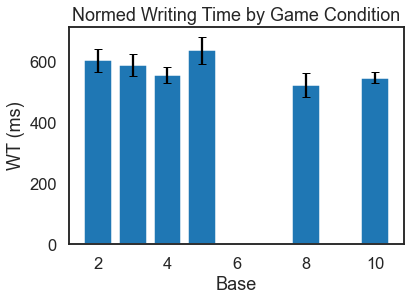

In [157]:
dv = 'RT'
# plot RT over game condition
fig , (ax1)= plt.subplots(1,1)

temp = get_confint(pd.DataFrame(Q.groupby(['base'])[[dv]].agg(['mean', 'count', 'std'])))

ax1.set_title("RT by Game Condition")
ax1.bar(temp.reset_index()['base'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
        capsize=4)
ax1.set_ylabel("RT (ms)")
ax1.set_xlabel("Base")

dv = 'WT'
# plot WT over game condition
fig , (ax1)= plt.subplots(1,1)

temp = get_confint(pd.DataFrame(Q.groupby(['base'])[[dv]].agg(['mean', 'count', 'std'])))

ax1.set_title("Writing Time by Game Condition")
ax1.bar(temp.reset_index()['base'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
        capsize=4)
ax1.set_ylabel("WT (ms)")
ax1.set_xlabel("Base")

dv = 'normedWT'
# plot normed WT over game condition
fig , (ax1)= plt.subplots(1,1)

temp = get_confint(pd.DataFrame(Q.groupby(['base'])[[dv]].agg(['mean', 'count', 'std'])))

ax1.set_title("Normed Writing Time by Game Condition")
ax1.bar(temp.reset_index()['base'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
        capsize=4)
ax1.set_ylabel("WT (ms)")
ax1.set_xlabel("Base")

Text(0.5, 0, 'Base')

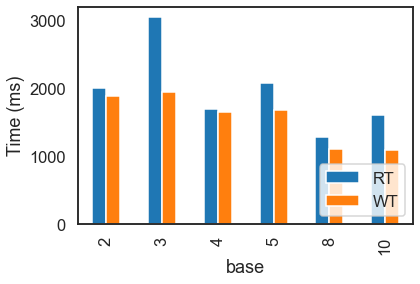

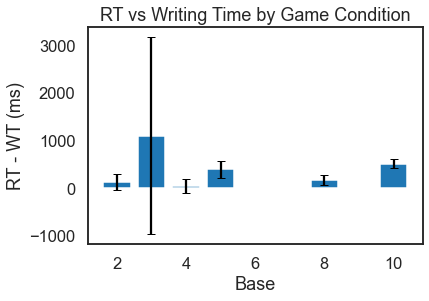

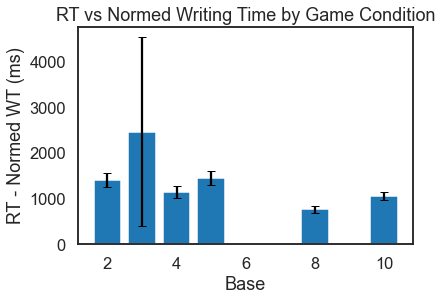

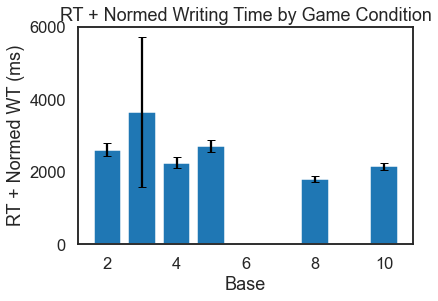

In [158]:
# plot RT and writing time over game condition
Q.groupby(['base'])[['RT','WT']].mean().plot.bar().legend(['RT','WT'],loc='lower right')
plt.ylabel("Time (ms)")


dv = 'RTLessWrite'
# plot RT - writing time over game condition
fig , (ax1)= plt.subplots(1,1)

temp = get_confint(pd.DataFrame(Q.groupby(['base'])[[dv]].agg(['mean', 'count', 'std'])))

ax1.set_title("RT vs Writing Time by Game Condition")
ax1.bar(temp.reset_index()['base'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
        capsize=4)
ax1.set_ylabel("RT - WT (ms)")
ax1.set_xlabel("Base")



dv = 'RTLessNormedWrite'
# plot RT - normed writing time over game condition
fig , (ax1)= plt.subplots(1,1)

temp = get_confint(pd.DataFrame(Q.groupby(['base'])[[dv]].agg(['mean', 'count', 'std'])))

ax1.set_title("RT vs Normed Writing Time by Game Condition")
ax1.bar(temp.reset_index()['base'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
        capsize=4)
ax1.set_ylabel("RT - Normed WT (ms)")
ax1.set_xlabel("Base")

dv = 'RTPlusNormedWrite'
# plot RT + normed writing time over game condition
fig , (ax1)= plt.subplots(1,1)

temp = get_confint(pd.DataFrame(Q.groupby(['base'])[[dv]].agg(['mean', 'count', 'std'])))

ax1.set_title("RT + Normed Writing Time by Game Condition")
ax1.bar(temp.reset_index()['base'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
        capsize=4)
ax1.set_ylabel("RT + Normed WT (ms)")
ax1.set_xlabel("Base")

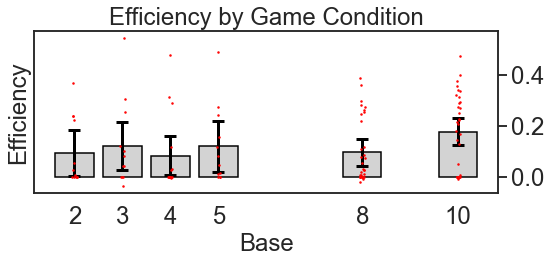

In [244]:
# cogsci_old

dv = 'efficiency'  # 'correct' or 'timeDV'

# plot normalized time DV over game condition
fig , (ax1)= plt.subplots(1,1,figsize=(8,4))

temp = get_confint(pd.DataFrame(Q.groupby(['base'])[[dv]].agg(['mean', 'count', 'std'])))

ax1.set_title("Efficiency by Game Condition")
ax1.bar(temp.reset_index()['base'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
        edgecolor='k',fill='lightgrey',color='lightgrey',
        error_kw={'linewidth':3,'capsize':6,'markeredgewidth':3})
ax1.set_xticks([2,3,4,5,8,10])
ax1.set_xticklabels(['2','3','4','5','8','10'])
ax1.set_ylabel("Efficiency")
ax1.set_xlabel("Base")
# ax1.set_yticks([0,2000,4000,6000])
# ax1.set_yticklabels(['0','2','4','6'])
ax1.yaxis.tick_right()


# ax1.set_ylim(0,6000)

# now we can also plot each individual game on average and see how they distribute
gameTimes = Q.groupby(['base','gameID'])[[dv]].mean().reset_index()
bases = [2,3,4,5,8,10]
for base in bases:
    ax1.scatter(base + np.random.random(len(gameTimes[gameTimes['base'] == base]))* .1 - .05,
                gameTimes[gameTimes['base'] == base][dv],
                zorder=10,s=1,c='r')

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(24)


plt.tight_layout()


fig.savefig('../results/plots/cogsci23/Exp1eff.pdf', bbox_inches="tight")


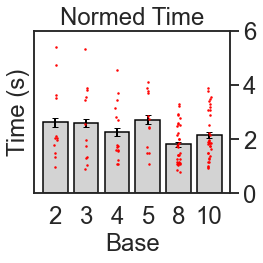

In [589]:
# cogsci_new

# trial structure looks like this:
# (stim. -> RT -> keypress. -> WT -> submit.)

lw = 2 # linewidth for the errorbars
ew = 1 # edgewidth for the errorbars
cs = 3 # capsize for the errorbars

# our pre-registered time DV looks like this:
Q['timeDV'] = Q.RT + (Q.WT / Q.response.str.len())

# get rid of outliers
Q.loc[Q['timeDV'] > Q[Q['base']==3][['timeDV']].agg(['std'])['timeDV'][0]*3, 'timeDV'] = np.nan


dv = 'timeDV'  # 'correct' or 'timeDV'
titles = "Normed Time" if dv == 'timeDV' else "Accuracy"
# plot normalized time DV over game condition
fig , (ax1)= plt.subplots(1,1,figsize=(4,4))

temp = get_confint(pd.DataFrame(Q.groupby(['base'])[[dv]].agg(['mean', 'count', 'std'])))
temp.index = temp.index.astype('str')

ax1.set_title("{}".format(titles))
ax1.bar(temp.reset_index()['base'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
        edgecolor='k',fill='lightgrey',color='lightgrey',
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew})
ax1.set_xticks([0,1,2,3,4,5])
ax1.set_xticklabels(['2','3','4','5','8','10'])
ax1.set_ylabel("{}".format("Time (s)"))
ax1.set_xlabel("Base")
ax1.set_yticks([0,2000,4000,6000])
ax1.set_yticklabels(['0','2','4','6'])
ax1.yaxis.tick_right()


ax1.set_ylim(0,6000)

# now we can also plot each individual game on average and see how they distribute
gameTimes = Q.groupby(['base','gameID'])[[dv]].mean().reset_index()
gameTimes.base = gameTimes.astype({'base':'str'})

bases = ['2','3','4','5','8','10']
for i,base in enumerate(bases):
    ax1.scatter(i + np.random.random(len(gameTimes[gameTimes['base'] == base]))* .1 - .05,
                gameTimes[gameTimes['base'] == base][dv],
                zorder=10,s=1,c='r')

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(24)


plt.tight_layout()


fig.savefig('../results/plots/cogsci23/Exp1rt.pdf', bbox_inches="tight")


In [582]:
temp.index = temp.index.astype('str')
gameTimes.index

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '107', '108', '109', '110', '111', '112', '113', '114', '115', '116'],
      dtype='object', length=117)

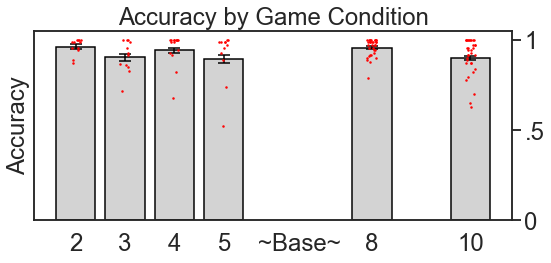

In [253]:
# cogsci_new

# trial structure looks like this:
# (stim. -> RT -> keypress. -> WT -> submit.)

lw = 1.5 # linewidth for the errorbars
cs = 6 # capsize for the errorbars

# our pre-registered time DV looks like this:
Q['timeDV'] = Q.RT + (Q.WT / Q.response.str.len())

# get rid of outliers
Q.loc[Q['timeDV'] > Q[Q['base']==3][['timeDV']].agg(['std'])['timeDV'][0]*3, 'timeDV'] = np.nan


dv = 'correct'  # 'correct' or 'timeDV'
titles = "Normed Time (ms)" if dv == 'timeDV' else "Accuracy"
# plot normalized time DV over game condition
fig , (ax1)= plt.subplots(1,1,figsize=(8,4))

temp = get_confint(pd.DataFrame(Q.groupby(['base'])[[dv]].agg(['mean', 'count', 'std'])))

ax1.set_title("{} by Game Condition".format(titles))
ax1.bar(temp.reset_index()['base'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
        edgecolor='k',fill='lightgrey',color='lightgrey',
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':lw})
ax1.set_xticks([2,3,4,5,6,8,10])
ax1.set_xticklabels(['2','3','4','5',"        ~Base~",'8','10'])
ax1.set_ylabel("{}".format(titles))
# ax1.set_xlabel("Base")
# ax1.set_ylim(0,8000)
ax1.set_yticks([0,.5,1])
ax1.set_yticklabels(['0','.5','1'])
ax1.yaxis.tick_right()


# now we can also plot each individual game on average and see how they distribute
gameTimes = Q.groupby(['base','gameID'])[[dv]].mean().reset_index()
bases = [2,3,4,5,8,10]
for base in bases:
    ax1.scatter(base + np.random.random(len(gameTimes[gameTimes['base'] == base]))* .2 - .1,
                gameTimes[gameTimes['base'] == base][dv],
                zorder=10,s=1,c='r')

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(24)

plt.tight_layout()

fig.savefig('../results/plots/cogsci23/Exp1acc.pdf', bbox_inches="tight")


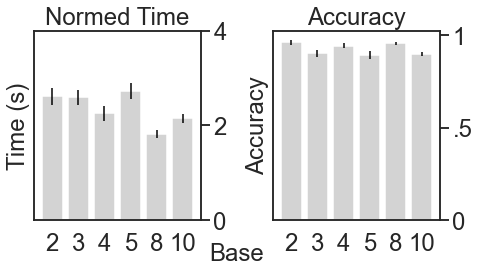

In [651]:
# cogsci_new

# trial structure looks like this:
# (stim. -> RT -> keypress. -> WT -> submit.)

fig , (ax1,ax2)= plt.subplots(1,2,figsize=(7,4))


d = .5 # how dispersed should the scatter dots be? Depends on width of bars
fs = 12 # fontsize for text in the figure
lw = 1.5 # linewidth for the errorbars
cs = 0 # capsize for the errorbars
ew = 0 # edgewidth for the errorbars

# our pre-registered time DV looks like this:
Q['timeDV'] = Q.RT + (Q.WT / Q.response.str.len())

# get rid of outliers
Q.loc[Q['timeDV'] > Q[Q['base']==3][['timeDV']].agg(['std'])['timeDV'][0]*3, 'timeDV'] = np.nan


dv = 'timeDV'  # 'correct' or 'timeDV'
titles = "Normed Time" if dv == 'timeDV' else "Accuracy"
# plot normalized time DV over game condition

temp = get_confint(pd.DataFrame(Q.groupby(['base'])[[dv]].agg(['mean', 'count', 'std'])))
temp.index = temp.index.astype('str')

ax1.set_title("{}".format(titles))
ax1.bar(temp.reset_index()['base'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
       # edgecolor='k',
        fill='lightgrey',color='lightgrey',
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew})
ax1.set_xticks([0,1,2,3,4,5])
ax1.set_xticklabels(['2','3','4','5','8','10'])
ax1.set_ylabel("{}".format("Time (s)"))
# ax1.set_xlabel("Base")
ax1.set_yticks([0,2000,4000])
ax1.set_yticklabels(['0','2','4'])
ax1.yaxis.tick_right()
# ax1.yaxis.set_label_position("right")


ax1.set_ylim(0,4000)

# now we can also plot each individual game on average and see how they distribute
gameTimes = Q.groupby(['base','gameID'])[[dv]].mean().reset_index()
gameTimes.base = gameTimes.astype({'base':'str'})

bases = ['2','3','4','5','8','10']
# for i,base in enumerate(bases):
#     ax1.scatter(i + np.random.random(len(gameTimes[gameTimes['base'] == base]))* .1 - .05,
#                 gameTimes[gameTimes['base'] == base][dv],
#                 zorder=10,s=1,c='r')

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(24)

    
    
    
    
    
    
    
    
    
dv = 'correct'  # 'correct' or 'timeDV'
titles = "Normed Time (ms)" if dv == 'timeDV' else "Accuracy"
# plot normalized time DV over game condition

temp = get_confint(pd.DataFrame(Q.groupby(['base'])[[dv]].agg(['mean', 'count', 'std'])))
temp.index = temp.index.astype('str')

ax2.set_title("{}".format(titles))
ax2.bar(temp.reset_index()['base'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
        #edgecolor='k',
        fill='lightgrey',color='lightgrey',
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew})
ax2.set_xticks([0,1,2,3,4,5])
ax2.set_xticklabels(['2','3','4','5','8','10'])
ax2.set_ylabel("{}".format(titles),rotation=90)
# ax2.set_xlabel("Base")
# ax2.set_ylim(0,8000)
ax2.set_yticks([0,.5,1])
ax2.set_yticklabels(['0','.5','1'])
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("left")


# now we can also plot each individual game on average and see how they distribute
gameTimes = Q.groupby(['base','gameID'])[[dv]].mean().reset_index()
gameTimes.base = gameTimes.astype({'base':'str'})
bases = ['2','3','4','5','8','10']
# for i,base in enumerate(bases):
#     ax2.scatter(i + np.random.random(len(gameTimes[gameTimes['base'] == base]))* .2 - .1,
#                 gameTimes[gameTimes['base'] == base][dv],
#                 zorder=10,s=1,c='r')

for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(24)

plt.figtext(.44,0.05,'Base',fontsize=24)

plt.tight_layout()


fig.savefig('../results/plots/cogsci23/Exp1main.pdf', bbox_inches="tight")


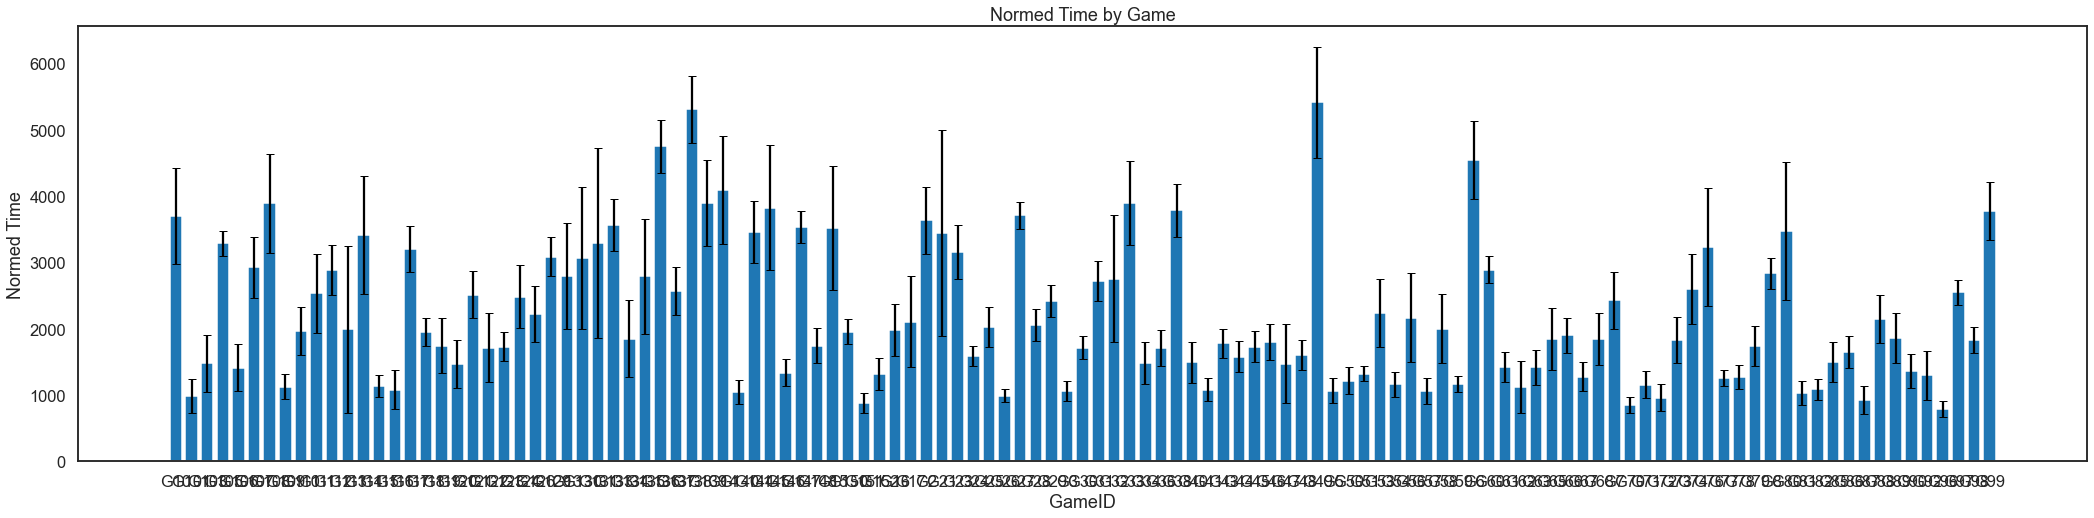

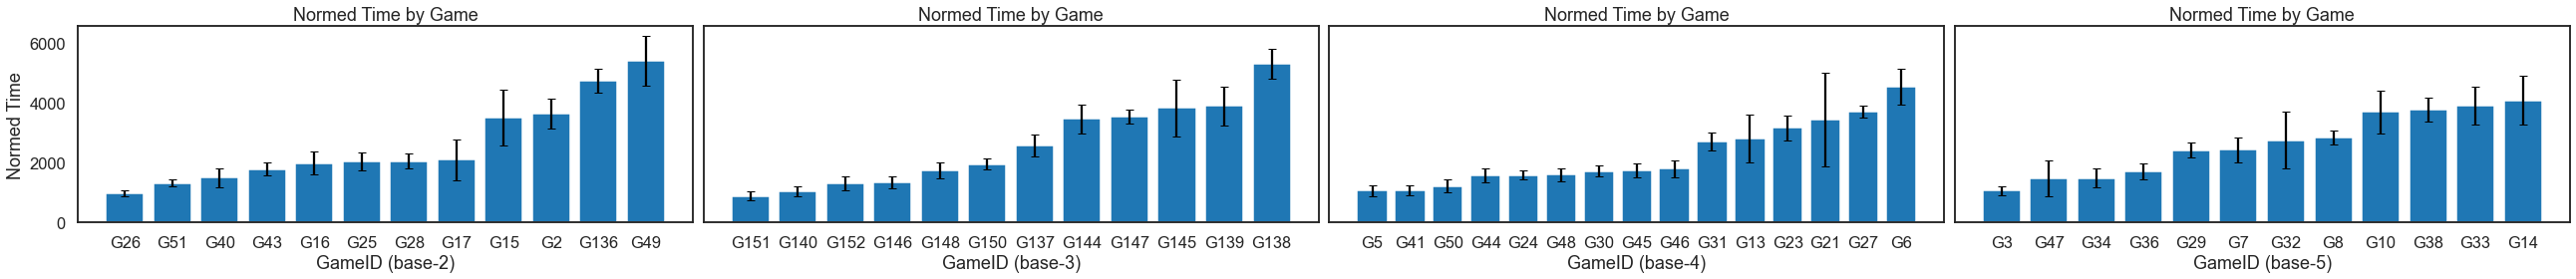

In [427]:

dv = 'timeDV'
# plot normalized time DV for every game (with error estimates)
fig , (ax1)= plt.subplots(1,1,figsize=(36,8))

temp = get_confint(pd.DataFrame(Q.groupby(['gameID'])[[dv]].agg(['mean', 'count', 'std'])))
 
ax1.set_title("Normed Time by Game")
ax1.bar(temp.reset_index()['gameID'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
        capsize=4)
ax1.set_ylabel("Normed Time")
ax1.set_xlabel("GameID")




dv = 'timeDV'
# plot normalized time DV for every game disaggregated over condition
fig , (ax2,ax3,ax4,ax5)= plt.subplots(1,4,figsize=(36,4),sharey=True)
axes = [ax2,ax3,ax4,ax5]
for i,base in enumerate([2,3,4,5]):
    temp = get_confint(pd.DataFrame(Q[Q['base']==base].groupby(['gameID'])[[dv]].agg(['mean', 'count', 'std']))).sort_values(( 'timeDV',  'mean'))   

    axes[i].set_title("Normed Time by Game")
    axes[i].bar(temp.reset_index()['gameID'],
            height=temp[dv]['mean'],
            width=.8,
            yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
            capsize=4)
    axes[0].set_ylabel("Normed Time")
    axes[i].set_xlabel("GameID (base-{})".format(base))

plt.tight_layout()


In [431]:
from sklearn.linear_model import LinearRegression
X = np.array(Q['base']).reshape(-1, 1)
y = np.array(Q['timeDV'].dropna()).reshape(-1, 1)  # you dropped 1 entry (a np.nan from one of the new base-3 games) so 1 entry from the ['base'] has to be dropped, too
reg = LinearRegression().fit(X, y)
reg.score(X, y)

reg.coef_

reg.intercept_



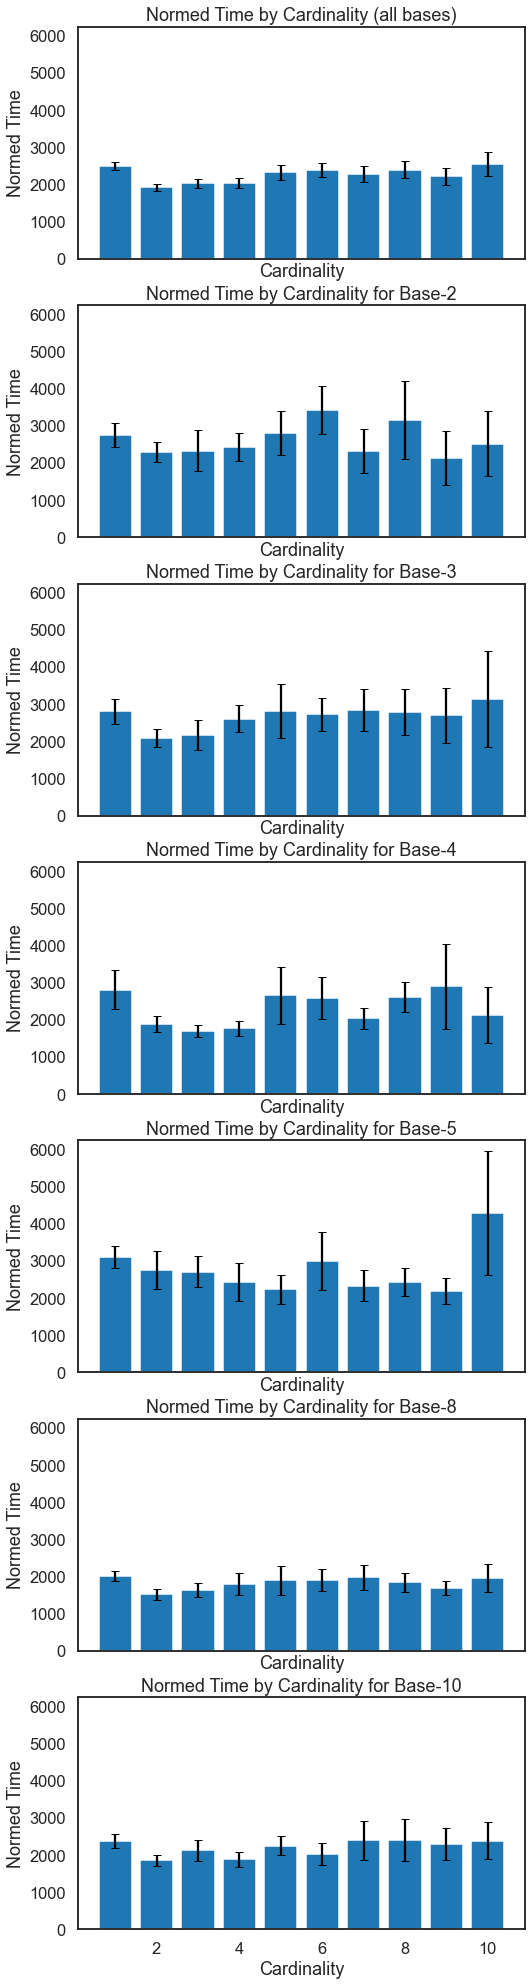

In [434]:
dv = 'timeDV'
fig , (ax1,ax2,ax3,ax4,ax5,ax8,ax10)= plt.subplots(7,1,figsize=(8,35),sharey=True,sharex=True)

temp = get_confint(pd.DataFrame(Q.groupby(['cardinality'])[[dv]].agg(['mean', 'count', 'std'])))

ax1.set_title("Normed Time by Cardinality (all bases)")
ax1.bar(temp.reset_index()['cardinality'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
        capsize=4)
ax1.set_ylabel("Normed Time")
ax1.set_xlabel("Cardinality")

bases = [2,3,4,5,8,10]
axs = [ax2,ax3,ax4,ax5,ax8,ax10]
for i,ax in enumerate(axs):
    temp = get_confint(pd.DataFrame(Q[Q['base'] == bases[i]].groupby(['cardinality'])[[dv]].agg(['mean', 'count', 'std'])))    
    ax.set_title("Normed Time by Cardinality for Base-{}".format(bases[i]))
    ax.bar(temp.reset_index()['cardinality'],
            height=temp[dv]['mean'],
            width=.8,
            yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
            capsize=4)
    ax.set_ylabel("Normed Time")
    ax.set_xlabel("Cardinality")


In [641]:
O[['correct']].mean()

correct    0.669643
dtype: float64

In [638]:
O[['missed']].mean()

missed    0.002976
dtype: float64

In [668]:

O.responseWord = O.responseWord.apply(lambda x: x.replace('-',''))
O.otherWord = O.otherWord.apply(lambda x: x.replace('-',''))

O['responseWordLen'] = O.responseWord.apply(lambda x: len(x))
O['otherWordLen'] = O.otherWord.apply(lambda x: len(x))


/Users/alles/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [669]:
O['dist'] = abs(O['responseNumber'] - O['otherNumber'])

O['word_len_diff'] = abs(O['responseWordLen'] - O['otherWordLen'])


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


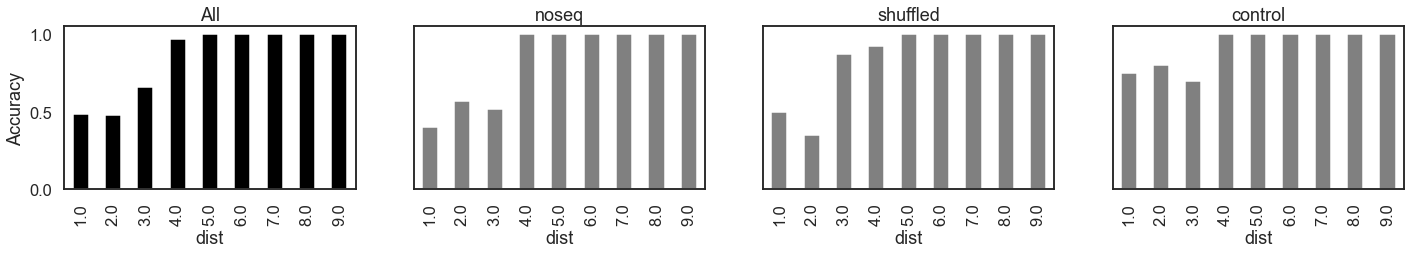

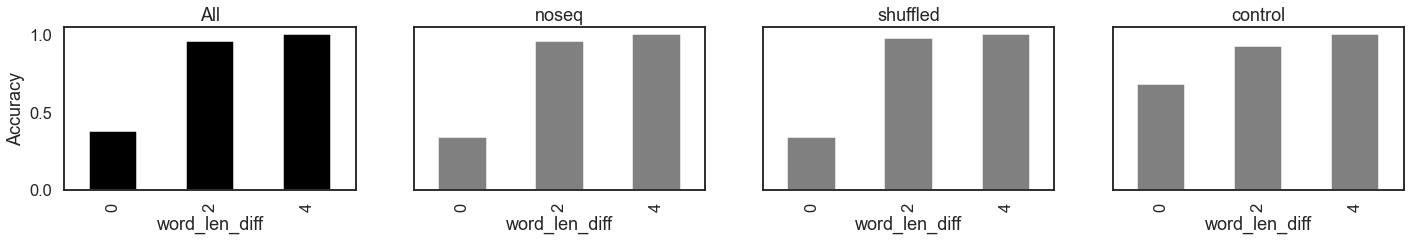

In [688]:
f , axs = plt.subplots(1,4,figsize=(24,3),sharey=True)
O.groupby(['dist'])[['correct']].mean().plot.bar(ax=axs[0],color='k',legend=False,title="All",ylabel="Accuracy")
for i,c in enumerate(conditions):
    O[O['condition']==c].groupby(['dist'])[['correct']].mean().plot.bar(ax=axs[i+1],color='gray',legend=False,title=c)
    
f , axs = plt.subplots(1,4,figsize=(24,3),sharey=True)
O.groupby(['word_len_diff'])[['correct']].mean().plot.bar(ax=axs[0],color='k',legend=False,title="All",ylabel="Accuracy")
for i,c in enumerate(conditions):
    O[O['condition']==c].groupby(['word_len_diff'])[['correct']].mean().plot.bar(ax=axs[i+1],color='gray',legend=False,title=c)


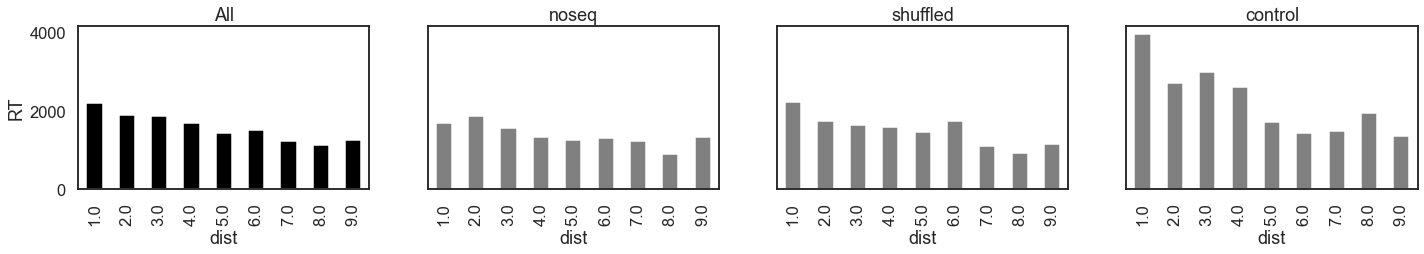

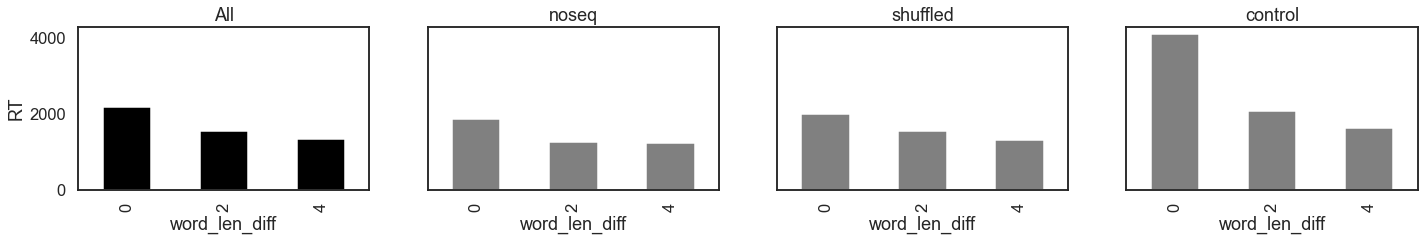

In [689]:
f , axs = plt.subplots(1,4,figsize=(24,3),sharey=True)
O.groupby(['dist'])[['RT']].mean().plot.bar(ax=axs[0],color='k',legend=False,title="All",ylabel="RT")
for i,c in enumerate(conditions):
    O[O['condition']==c].groupby(['dist'])[['RT']].mean().plot.bar(ax=axs[i+1],color='gray',legend=False,title=c)
    
f , axs = plt.subplots(1,4,figsize=(24,3),sharey=True)
O.groupby(['word_len_diff'])[['RT']].mean().plot.bar(ax=axs[0],color='k',legend=False,title="All",ylabel="RT")
for i,c in enumerate(conditions):
    O[O['condition']==c].groupby(['word_len_diff'])[['RT']].mean().plot.bar(ax=axs[i+1],color='gray',legend=False,title=c)
